# Lung Segmentation Using the Montgomery Dataset

In [1]:
import os
import tempfile
from typing import Any, Dict, List

import cv2
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt

import fastestimator as fe
from fastestimator.architecture.pytorch import UNet
from fastestimator.dataset.data import montgomery
from fastestimator.op.numpyop import Delete, NumpyOp
from fastestimator.op.numpyop.meta import Sometimes
from fastestimator.op.numpyop.multivariate import HorizontalFlip, Resize, Rotate
from fastestimator.op.numpyop.univariate import Minmax, ReadImage, Reshape
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import Dice

In [2]:
pd.set_option('display.max_colwidth', 500)

In [3]:
batch_size = 4
epochs = 25
max_train_steps_per_epoch = None
max_eval_steps_per_epoch = None
save_dir = tempfile.mkdtemp()
data_dir = None

In [4]:
# Parameters
epochs = 2
batch_size = 8
max_train_steps_per_epoch = 10
max_eval_steps_per_epoch = 10


# Download Data

We download the Montgomery data first:

In [5]:
csv = montgomery.load_data(root_dir=data_dir)

  0% [                                                  ]      0.07 / 616.85 MB

  0% [                                                  ]      0.25 / 616.85 MB

  0% [                                                  ]      0.61 / 616.85 MB

  0% [                                                  ]      0.80 / 616.85 MB

  0% [                                                  ]      0.97 / 616.85 MB

  0% [                                                  ]      1.05 / 616.85 MB

  0% [                                                  ]      1.18 / 616.85 MB

  0% [                                                  ]      1.29 / 616.85 MB

  0% [                                                  ]      1.43 / 616.85 MB

  0% [                                                  ]      1.52 / 616.85 MB

  0% [                                                  ]      1.64 / 616.85 MB

  0% [                                                  ]      1.75 / 616.85 MB

  0% [                                                  ]      1.88 / 616.85 MB

  0% [                                                  ]      1.95 / 616.85 MB

  0% [                                                  ]      2.10 / 616.85 MB

  0% [                                                  ]      2.20 / 616.85 MB

  0% [                                                  ]      2.33 / 616.85 MB

  0% [                                                  ]      2.44 / 616.85 MB

  0% [                                                  ]      2.54 / 616.85 MB

  0% [                                                  ]      2.69 / 616.85 MB

  0% [                                                  ]      2.80 / 616.85 MB

  0% [                                                  ]      2.92 / 616.85 MB

  0% [                                                  ]      3.03 / 616.85 MB

  0% [                                                  ]      3.15 / 616.85 MB

  0% [                                                  ]      3.26 / 616.85 MB

  0% [                                                  ]      3.36 / 616.85 MB

  0% [                                                  ]      3.47 / 616.85 MB

  0% [                                                  ]      3.59 / 616.85 MB

  0% [                                                  ]      3.70 / 616.85 MB

  0% [                                                  ]      3.80 / 616.85 MB

  0% [                                                  ]      3.92 / 616.85 MB

  0% [                                                  ]      4.03 / 616.85 MB

  0% [                                                  ]      4.15 / 616.85 MB

  0% [                                                  ]      4.23 / 616.85 MB

  0% [                                                  ]      4.33 / 616.85 MB

  0% [                                                  ]      4.41 / 616.85 MB

  0% [                                                  ]      4.51 / 616.85 MB

  0% [                                                  ]      4.59 / 616.85 MB

  0% [                                                  ]      4.69 / 616.85 MB

  0% [                                                  ]      4.77 / 616.85 MB

  0% [                                                  ]      4.85 / 616.85 MB

  0% [                                                  ]      4.93 / 616.85 MB

  0% [                                                  ]      5.02 / 616.85 MB

  0% [                                                  ]      5.10 / 616.85 MB

  0% [                                                  ]      5.19 / 616.85 MB

  0% [                                                  ]      5.28 / 616.85 MB

  0% [                                                  ]      5.39 / 616.85 MB

  0% [                                                  ]      5.51 / 616.85 MB

  0% [                                                  ]      5.60 / 616.85 MB

  0% [                                                  ]      5.72 / 616.85 MB

  0% [                                                  ]      5.83 / 616.85 MB

  0% [                                                  ]      5.93 / 616.85 MB

  0% [                                                  ]      6.05 / 616.85 MB

  0% [                                                  ]      6.16 / 616.85 MB

  1% [                                                  ]      6.28 / 616.85 MB

  1% [                                                  ]      6.37 / 616.85 MB

  1% [                                                  ]      6.44 / 616.85 MB

  1% [                                                  ]      6.52 / 616.85 MB

  1% [                                                  ]      6.62 / 616.85 MB

  1% [                                                  ]      6.72 / 616.85 MB

  1% [                                                  ]      6.82 / 616.85 MB

  1% [                                                  ]      6.95 / 616.85 MB

  1% [                                                  ]      7.06 / 616.85 MB

  1% [                                                  ]      7.19 / 616.85 MB

  1% [                                                  ]      7.29 / 616.85 MB

  1% [                                                  ]      7.42 / 616.85 MB

  1% [                                                  ]      7.52 / 616.85 MB

  1% [                                                  ]      7.65 / 616.85 MB

  1% [                                                  ]      7.75 / 616.85 MB

  1% [                                                  ]      7.88 / 616.85 MB

  1% [                                                  ]      8.01 / 616.85 MB

  1% [                                                  ]      8.11 / 616.85 MB

  1% [                                                  ]      8.24 / 616.85 MB

  1% [                                                  ]      8.34 / 616.85 MB

  1% [                                                  ]      8.45 / 616.85 MB

  1% [                                                  ]      8.57 / 616.85 MB

  1% [                                                  ]      8.70 / 616.85 MB

  1% [                                                  ]      8.81 / 616.85 MB

  1% [                                                  ]      8.95 / 616.85 MB

  1% [                                                  ]      9.08 / 616.85 MB

  1% [                                                  ]      9.20 / 616.85 MB

  1% [                                                  ]      9.31 / 616.85 MB

  1% [                                                  ]      9.42 / 616.85 MB

  1% [                                                  ]      9.58 / 616.85 MB

  1% [                                                  ]      9.72 / 616.85 MB

  1% [                                                  ]      9.88 / 616.85 MB

  1% [                                                  ]     10.01 / 616.85 MB

  1% [                                                  ]     10.20 / 616.85 MB

  1% [                                                  ]     10.35 / 616.85 MB

  1% [                                                  ]     10.52 / 616.85 MB

  1% [                                                  ]     10.73 / 616.85 MB

  1% [                                                  ]     10.93 / 616.85 MB

  1% [                                                  ]     11.12 / 616.85 MB

  1% [                                                  ]     11.34 / 616.85 MB

  1% [                                                  ]     11.52 / 616.85 MB

  1% [                                                  ]     11.62 / 616.85 MB

  1% [                                                  ]     11.85 / 616.85 MB

  1% [                                                  ]     11.98 / 616.85 MB

  1% [                                                  ]     12.14 / 616.85 MB

  1% [                                                  ]     12.32 / 616.85 MB

  2% [.                                                 ]     12.47 / 616.85 MB

  2% [.                                                 ]     12.58 / 616.85 MB

  2% [.                                                 ]     12.70 / 616.85 MB

  2% [.                                                 ]     12.81 / 616.85 MB

  2% [.                                                 ]     12.93 / 616.85 MB

  2% [.                                                 ]     13.04 / 616.85 MB

  2% [.                                                 ]     13.16 / 616.85 MB

  2% [.                                                 ]     13.27 / 616.85 MB

  2% [.                                                 ]     13.39 / 616.85 MB

  2% [.                                                 ]     13.50 / 616.85 MB

  2% [.                                                 ]     13.63 / 616.85 MB

  2% [.                                                 ]     13.75 / 616.85 MB

  2% [.                                                 ]     13.88 / 616.85 MB

  2% [.                                                 ]     13.98 / 616.85 MB

  2% [.                                                 ]     14.11 / 616.85 MB

  2% [.                                                 ]     14.20 / 616.85 MB

  2% [.                                                 ]     14.32 / 616.85 MB

  2% [.                                                 ]     14.43 / 616.85 MB

  2% [.                                                 ]     14.55 / 616.85 MB

  2% [.                                                 ]     14.66 / 616.85 MB

  2% [.                                                 ]     14.79 / 616.85 MB

  2% [.                                                 ]     14.91 / 616.85 MB

  2% [.                                                 ]     15.04 / 616.85 MB

  2% [.                                                 ]     15.16 / 616.85 MB

  2% [.                                                 ]     15.30 / 616.85 MB

  2% [.                                                 ]     15.43 / 616.85 MB

  2% [.                                                 ]     15.56 / 616.85 MB

  2% [.                                                 ]     15.70 / 616.85 MB

  2% [.                                                 ]     15.79 / 616.85 MB

  2% [.                                                 ]     15.89 / 616.85 MB

  2% [.                                                 ]     16.06 / 616.85 MB

  2% [.                                                 ]     16.20 / 616.85 MB

  2% [.                                                 ]     16.33 / 616.85 MB

  2% [.                                                 ]     16.47 / 616.85 MB

  2% [.                                                 ]     16.56 / 616.85 MB

  2% [.                                                 ]     16.70 / 616.85 MB

  2% [.                                                 ]     16.79 / 616.85 MB

  2% [.                                                 ]     16.92 / 616.85 MB

  2% [.                                                 ]     17.02 / 616.85 MB

  2% [.                                                 ]     17.15 / 616.85 MB

  2% [.                                                 ]     17.27 / 616.85 MB

  2% [.                                                 ]     17.37 / 616.85 MB

  2% [.                                                 ]     17.51 / 616.85 MB

  2% [.                                                 ]     17.60 / 616.85 MB

  2% [.                                                 ]     17.69 / 616.85 MB

  2% [.                                                 ]     17.81 / 616.85 MB

  2% [.                                                 ]     17.94 / 616.85 MB

  2% [.                                                 ]     18.02 / 616.85 MB

  2% [.                                                 ]     18.17 / 616.85 MB

  2% [.                                                 ]     18.27 / 616.85 MB

  2% [.                                                 ]     18.40 / 616.85 MB

  3% [.                                                 ]     18.51 / 616.85 MB

  3% [.                                                 ]     18.64 / 616.85 MB

  3% [.                                                 ]     18.78 / 616.85 MB

  3% [.                                                 ]     18.89 / 616.85 MB

  3% [.                                                 ]     19.01 / 616.85 MB

  3% [.                                                 ]     19.14 / 616.85 MB

  3% [.                                                 ]     19.27 / 616.85 MB

  3% [.                                                 ]     19.40 / 616.85 MB

  3% [.                                                 ]     19.50 / 616.85 MB

  3% [.                                                 ]     19.63 / 616.85 MB

  3% [.                                                 ]     19.73 / 616.85 MB

  3% [.                                                 ]     19.81 / 616.85 MB

  3% [.                                                 ]     19.91 / 616.85 MB

  3% [.                                                 ]     19.99 / 616.85 MB

  3% [.                                                 ]     20.09 / 616.85 MB

  3% [.                                                 ]     20.17 / 616.85 MB

  3% [.                                                 ]     20.27 / 616.85 MB

  3% [.                                                 ]     20.38 / 616.85 MB

  3% [.                                                 ]     20.50 / 616.85 MB

  3% [.                                                 ]     20.61 / 616.85 MB

  3% [.                                                 ]     20.69 / 616.85 MB

  3% [.                                                 ]     20.82 / 616.85 MB

  3% [.                                                 ]     20.96 / 616.85 MB

  3% [.                                                 ]     21.10 / 616.85 MB

  3% [.                                                 ]     21.25 / 616.85 MB

  3% [.                                                 ]     21.41 / 616.85 MB

  3% [.                                                 ]     21.54 / 616.85 MB

  3% [.                                                 ]     21.69 / 616.85 MB

  3% [.                                                 ]     21.82 / 616.85 MB

  3% [.                                                 ]     21.97 / 616.85 MB

  3% [.                                                 ]     22.12 / 616.85 MB

  3% [.                                                 ]     22.28 / 616.85 MB

  3% [.                                                 ]     22.46 / 616.85 MB

  3% [.                                                 ]     22.64 / 616.85 MB

  3% [.                                                 ]     22.81 / 616.85 MB

  3% [.                                                 ]     22.99 / 616.85 MB

  3% [.                                                 ]     23.17 / 616.85 MB

  3% [.                                                 ]     23.33 / 616.85 MB

  3% [.                                                 ]     23.51 / 616.85 MB

  3% [.                                                 ]     23.69 / 616.85 MB

  3% [.                                                 ]     23.87 / 616.85 MB

  3% [.                                                 ]     24.07 / 616.85 MB

  3% [.                                                 ]     24.22 / 616.85 MB

  3% [.                                                 ]     24.35 / 616.85 MB

  3% [.                                                 ]     24.48 / 616.85 MB

  3% [.                                                 ]     24.63 / 616.85 MB

  4% [..                                                ]     24.77 / 616.85 MB

  4% [..                                                ]     24.92 / 616.85 MB

  4% [..                                                ]     25.07 / 616.85 MB

  4% [..                                                ]     25.23 / 616.85 MB

  4% [..                                                ]     25.40 / 616.85 MB

  4% [..                                                ]     25.56 / 616.85 MB

  4% [..                                                ]     25.71 / 616.85 MB

  4% [..                                                ]     25.87 / 616.85 MB

  4% [..                                                ]     26.03 / 616.85 MB

  4% [..                                                ]     26.21 / 616.85 MB

  4% [..                                                ]     26.39 / 616.85 MB

  4% [..                                                ]     26.56 / 616.85 MB

  4% [..                                                ]     26.74 / 616.85 MB

  4% [..                                                ]     26.90 / 616.85 MB

  4% [..                                                ]     27.07 / 616.85 MB

  4% [..                                                ]     27.25 / 616.85 MB

  4% [..                                                ]     27.44 / 616.85 MB

  4% [..                                                ]     27.62 / 616.85 MB

  4% [..                                                ]     27.80 / 616.85 MB

  4% [..                                                ]     27.98 / 616.85 MB

  4% [..                                                ]     28.16 / 616.85 MB

  4% [..                                                ]     28.33 / 616.85 MB

  4% [..                                                ]     28.51 / 616.85 MB

  4% [..                                                ]     28.66 / 616.85 MB

  4% [..                                                ]     28.85 / 616.85 MB

  4% [..                                                ]     29.02 / 616.85 MB

  4% [..                                                ]     29.20 / 616.85 MB

  4% [..                                                ]     29.43 / 616.85 MB

  4% [..                                                ]     29.62 / 616.85 MB

  4% [..                                                ]     29.80 / 616.85 MB

  4% [..                                                ]     30.03 / 616.85 MB

  4% [..                                                ]     30.23 / 616.85 MB

  4% [..                                                ]     30.43 / 616.85 MB

  4% [..                                                ]     30.65 / 616.85 MB

  5% [..                                                ]     30.88 / 616.85 MB

  5% [..                                                ]     31.13 / 616.85 MB

  5% [..                                                ]     31.36 / 616.85 MB

  5% [..                                                ]     31.44 / 616.85 MB

  5% [..                                                ]     31.52 / 616.85 MB

  5% [..                                                ]     31.60 / 616.85 MB

  5% [..                                                ]     31.69 / 616.85 MB

  5% [..                                                ]     31.80 / 616.85 MB

  5% [..                                                ]     31.93 / 616.85 MB

  5% [..                                                ]     32.08 / 616.85 MB

  5% [..                                                ]     32.23 / 616.85 MB

  5% [..                                                ]     32.37 / 616.85 MB

  5% [..                                                ]     32.52 / 616.85 MB

  5% [..                                                ]     32.70 / 616.85 MB

  5% [..                                                ]     32.88 / 616.85 MB

  5% [..                                                ]     33.08 / 616.85 MB

  5% [..                                                ]     33.26 / 616.85 MB

  5% [..                                                ]     33.47 / 616.85 MB

  5% [..                                                ]     33.67 / 616.85 MB

  5% [..                                                ]     33.88 / 616.85 MB

  5% [..                                                ]     34.06 / 616.85 MB

  5% [..                                                ]     34.28 / 616.85 MB

  5% [..                                                ]     34.44 / 616.85 MB

  5% [..                                                ]     34.64 / 616.85 MB

  5% [..                                                ]     34.85 / 616.85 MB

  5% [..                                                ]     35.01 / 616.85 MB

  5% [..                                                ]     35.16 / 616.85 MB

  5% [..                                                ]     35.32 / 616.85 MB

  5% [..                                                ]     35.49 / 616.85 MB

  5% [..                                                ]     35.64 / 616.85 MB

  5% [..                                                ]     35.80 / 616.85 MB

  5% [..                                                ]     35.95 / 616.85 MB

  5% [..                                                ]     36.09 / 616.85 MB

  5% [..                                                ]     36.24 / 616.85 MB

  5% [..                                                ]     36.39 / 616.85 MB

  5% [..                                                ]     36.54 / 616.85 MB

  5% [..                                                ]     36.67 / 616.85 MB

  5% [..                                                ]     36.78 / 616.85 MB

  5% [..                                                ]     36.91 / 616.85 MB

  6% [...                                               ]     37.03 / 616.85 MB

  6% [...                                               ]     37.18 / 616.85 MB

  6% [...                                               ]     37.31 / 616.85 MB

  6% [...                                               ]     37.44 / 616.85 MB

  6% [...                                               ]     37.58 / 616.85 MB

  6% [...                                               ]     37.70 / 616.85 MB

  6% [...                                               ]     37.83 / 616.85 MB

  6% [...                                               ]     37.95 / 616.85 MB

  6% [...                                               ]     38.08 / 616.85 MB

  6% [...                                               ]     38.19 / 616.85 MB

  6% [...                                               ]     38.31 / 616.85 MB

  6% [...                                               ]     38.40 / 616.85 MB

  6% [...                                               ]     38.54 / 616.85 MB

  6% [...                                               ]     38.67 / 616.85 MB

  6% [...                                               ]     38.78 / 616.85 MB

  6% [...                                               ]     38.91 / 616.85 MB

  6% [...                                               ]     39.03 / 616.85 MB

  6% [...                                               ]     39.16 / 616.85 MB

  6% [...                                               ]     39.26 / 616.85 MB

  6% [...                                               ]     39.31 / 616.85 MB

  6% [...                                               ]     39.37 / 616.85 MB

  6% [...                                               ]     39.45 / 616.85 MB

  6% [...                                               ]     39.52 / 616.85 MB

  6% [...                                               ]     39.60 / 616.85 MB

  6% [...                                               ]     39.67 / 616.85 MB

  6% [...                                               ]     39.75 / 616.85 MB

  6% [...                                               ]     39.83 / 616.85 MB

  6% [...                                               ]     39.90 / 616.85 MB

  6% [...                                               ]     39.98 / 616.85 MB

  6% [...                                               ]     40.04 / 616.85 MB

  6% [...                                               ]     40.11 / 616.85 MB

  6% [...                                               ]     40.17 / 616.85 MB

  6% [...                                               ]     40.26 / 616.85 MB

  6% [...                                               ]     40.34 / 616.85 MB

  6% [...                                               ]     40.42 / 616.85 MB

  6% [...                                               ]     40.50 / 616.85 MB

  6% [...                                               ]     40.58 / 616.85 MB

  6% [...                                               ]     40.67 / 616.85 MB

  6% [...                                               ]     40.68 / 616.85 MB

  6% [...                                               ]     40.75 / 616.85 MB

  6% [...                                               ]     40.81 / 616.85 MB

  6% [...                                               ]     40.88 / 616.85 MB

  6% [...                                               ]     40.96 / 616.85 MB

  6% [...                                               ]     40.98 / 616.85 MB

  6% [...                                               ]     41.04 / 616.85 MB

  6% [...                                               ]     41.09 / 616.85 MB

  6% [...                                               ]     41.14 / 616.85 MB

  6% [...                                               ]     41.21 / 616.85 MB

  6% [...                                               ]     41.27 / 616.85 MB

  6% [...                                               ]     41.35 / 616.85 MB

  6% [...                                               ]     41.45 / 616.85 MB

  6% [...                                               ]     41.55 / 616.85 MB

  6% [...                                               ]     41.65 / 616.85 MB

  6% [...                                               ]     41.75 / 616.85 MB

  6% [...                                               ]     41.83 / 616.85 MB

  6% [...                                               ]     41.93 / 616.85 MB

  6% [...                                               ]     42.04 / 616.85 MB

  6% [...                                               ]     42.16 / 616.85 MB

  6% [...                                               ]     42.27 / 616.85 MB

  6% [...                                               ]     42.39 / 616.85 MB

  6% [...                                               ]     42.51 / 616.85 MB

  6% [...                                               ]     42.61 / 616.85 MB

  6% [...                                               ]     42.73 / 616.85 MB

  6% [...                                               ]     42.86 / 616.85 MB

  6% [...                                               ]     42.98 / 616.85 MB

  6% [...                                               ]     43.11 / 616.85 MB

  6% [...                                               ]     43.16 / 616.85 MB

  7% [...                                               ]     43.27 / 616.85 MB

  7% [...                                               ]     43.37 / 616.85 MB

  7% [...                                               ]     43.43 / 616.85 MB

  7% [...                                               ]     43.53 / 616.85 MB

  7% [...                                               ]     43.65 / 616.85 MB

  7% [...                                               ]     43.75 / 616.85 MB

  7% [...                                               ]     43.84 / 616.85 MB

  7% [...                                               ]     43.96 / 616.85 MB

  7% [...                                               ]     44.07 / 616.85 MB

  7% [...                                               ]     44.17 / 616.85 MB

  7% [...                                               ]     44.29 / 616.85 MB

  7% [...                                               ]     44.38 / 616.85 MB

  7% [...                                               ]     44.50 / 616.85 MB

  7% [...                                               ]     44.56 / 616.85 MB

  7% [...                                               ]     44.70 / 616.85 MB

  7% [...                                               ]     44.78 / 616.85 MB

  7% [...                                               ]     44.86 / 616.85 MB

  7% [...                                               ]     44.92 / 616.85 MB

  7% [...                                               ]     44.99 / 616.85 MB

  7% [...                                               ]     45.06 / 616.85 MB

  7% [...                                               ]     45.12 / 616.85 MB

  7% [...                                               ]     45.19 / 616.85 MB

  7% [...                                               ]     45.27 / 616.85 MB

  7% [...                                               ]     45.37 / 616.85 MB

  7% [...                                               ]     45.45 / 616.85 MB

  7% [...                                               ]     45.53 / 616.85 MB

  7% [...                                               ]     45.63 / 616.85 MB

  7% [...                                               ]     45.73 / 616.85 MB

  7% [...                                               ]     45.83 / 616.85 MB

  7% [...                                               ]     45.94 / 616.85 MB

  7% [...                                               ]     46.04 / 616.85 MB

  7% [...                                               ]     46.17 / 616.85 MB

  7% [...                                               ]     46.30 / 616.85 MB

  7% [...                                               ]     46.44 / 616.85 MB

  7% [...                                               ]     46.56 / 616.85 MB

  7% [...                                               ]     46.69 / 616.85 MB

  7% [...                                               ]     46.86 / 616.85 MB

  7% [...                                               ]     47.01 / 616.85 MB

  7% [...                                               ]     47.17 / 616.85 MB

  7% [...                                               ]     47.33 / 616.85 MB

  7% [...                                               ]     47.48 / 616.85 MB

  7% [...                                               ]     47.68 / 616.85 MB

  7% [...                                               ]     47.79 / 616.85 MB

  7% [...                                               ]     47.89 / 616.85 MB

  7% [...                                               ]     47.99 / 616.85 MB

  7% [...                                               ]     48.09 / 616.85 MB

  7% [...                                               ]     48.20 / 616.85 MB

  7% [...                                               ]     48.30 / 616.85 MB

  7% [...                                               ]     48.43 / 616.85 MB

  7% [...                                               ]     48.56 / 616.85 MB

  7% [...                                               ]     48.68 / 616.85 MB

  7% [...                                               ]     48.82 / 616.85 MB

  7% [...                                               ]     48.96 / 616.85 MB

  7% [...                                               ]     49.12 / 616.85 MB

  7% [...                                               ]     49.28 / 616.85 MB

  8% [....                                              ]     49.45 / 616.85 MB

  8% [....                                              ]     49.59 / 616.85 MB

  8% [....                                              ]     49.74 / 616.85 MB

  8% [....                                              ]     49.92 / 616.85 MB

  8% [....                                              ]     50.08 / 616.85 MB

  8% [....                                              ]     50.22 / 616.85 MB

  8% [....                                              ]     50.36 / 616.85 MB

  8% [....                                              ]     50.50 / 616.85 MB

  8% [....                                              ]     50.63 / 616.85 MB

  8% [....                                              ]     50.79 / 616.85 MB

  8% [....                                              ]     50.94 / 616.85 MB

  8% [....                                              ]     51.09 / 616.85 MB

  8% [....                                              ]     51.23 / 616.85 MB

  8% [....                                              ]     51.36 / 616.85 MB

  8% [....                                              ]     51.53 / 616.85 MB

  8% [....                                              ]     51.71 / 616.85 MB

  8% [....                                              ]     51.82 / 616.85 MB

  8% [....                                              ]     51.92 / 616.85 MB

  8% [....                                              ]     52.04 / 616.85 MB

  8% [....                                              ]     52.17 / 616.85 MB

  8% [....                                              ]     52.30 / 616.85 MB

  8% [....                                              ]     52.43 / 616.85 MB

  8% [....                                              ]     52.56 / 616.85 MB

  8% [....                                              ]     52.71 / 616.85 MB

  8% [....                                              ]     52.85 / 616.85 MB

  8% [....                                              ]     53.02 / 616.85 MB

  8% [....                                              ]     53.18 / 616.85 MB

  8% [....                                              ]     53.35 / 616.85 MB

  8% [....                                              ]     53.51 / 616.85 MB

  8% [....                                              ]     53.69 / 616.85 MB

  8% [....                                              ]     53.82 / 616.85 MB

  8% [....                                              ]     53.95 / 616.85 MB

  8% [....                                              ]     54.07 / 616.85 MB

  8% [....                                              ]     54.20 / 616.85 MB

  8% [....                                              ]     54.31 / 616.85 MB

  8% [....                                              ]     54.44 / 616.85 MB

  8% [....                                              ]     54.56 / 616.85 MB

  8% [....                                              ]     54.71 / 616.85 MB

  8% [....                                              ]     54.80 / 616.85 MB

  8% [....                                              ]     54.92 / 616.85 MB

  8% [....                                              ]     55.05 / 616.85 MB

  8% [....                                              ]     55.18 / 616.85 MB

  8% [....                                              ]     55.30 / 616.85 MB

  8% [....                                              ]     55.43 / 616.85 MB

  9% [....                                              ]     55.53 / 616.85 MB

  9% [....                                              ]     55.66 / 616.85 MB

  9% [....                                              ]     55.79 / 616.85 MB

  9% [....                                              ]     55.89 / 616.85 MB

  9% [....                                              ]     56.02 / 616.85 MB

  9% [....                                              ]     56.12 / 616.85 MB

  9% [....                                              ]     56.25 / 616.85 MB

  9% [....                                              ]     56.36 / 616.85 MB

  9% [....                                              ]     56.49 / 616.85 MB

  9% [....                                              ]     56.61 / 616.85 MB

  9% [....                                              ]     56.74 / 616.85 MB

  9% [....                                              ]     56.89 / 616.85 MB

  9% [....                                              ]     57.00 / 616.85 MB

  9% [....                                              ]     57.11 / 616.85 MB

  9% [....                                              ]     57.25 / 616.85 MB

  9% [....                                              ]     57.34 / 616.85 MB

  9% [....                                              ]     57.46 / 616.85 MB

  9% [....                                              ]     57.59 / 616.85 MB

  9% [....                                              ]     57.75 / 616.85 MB

  9% [....                                              ]     57.93 / 616.85 MB

  9% [....                                              ]     58.11 / 616.85 MB

  9% [....                                              ]     58.29 / 616.85 MB

  9% [....                                              ]     58.46 / 616.85 MB

  9% [....                                              ]     58.64 / 616.85 MB

  9% [....                                              ]     58.82 / 616.85 MB

  9% [....                                              ]     59.02 / 616.85 MB

  9% [....                                              ]     59.21 / 616.85 MB

  9% [....                                              ]     59.38 / 616.85 MB

  9% [....                                              ]     59.56 / 616.85 MB

  9% [....                                              ]     59.72 / 616.85 MB

  9% [....                                              ]     59.90 / 616.85 MB

  9% [....                                              ]     60.10 / 616.85 MB

  9% [....                                              ]     60.28 / 616.85 MB

  9% [....                                              ]     60.49 / 616.85 MB

  9% [....                                              ]     60.70 / 616.85 MB

  9% [....                                              ]     60.90 / 616.85 MB

  9% [....                                              ]     61.11 / 616.85 MB

  9% [....                                              ]     61.31 / 616.85 MB

  9% [....                                              ]     61.54 / 616.85 MB

 10% [.....                                             ]     61.73 / 616.85 MB

 10% [.....                                             ]     61.98 / 616.85 MB

 10% [.....                                             ]     62.23 / 616.85 MB

 10% [.....                                             ]     62.49 / 616.85 MB

 10% [.....                                             ]     62.69 / 616.85 MB

 10% [.....                                             ]     62.83 / 616.85 MB

 10% [.....                                             ]     63.03 / 616.85 MB

 10% [.....                                             ]     63.19 / 616.85 MB

 10% [.....                                             ]     63.39 / 616.85 MB

 10% [.....                                             ]     63.55 / 616.85 MB

 10% [.....                                             ]     63.77 / 616.85 MB

 10% [.....                                             ]     64.00 / 616.85 MB

 10% [.....                                             ]     64.26 / 616.85 MB

 10% [.....                                             ]     64.50 / 616.85 MB

 10% [.....                                             ]     64.78 / 616.85 MB

 10% [.....                                             ]     65.04 / 616.85 MB

 10% [.....                                             ]     65.32 / 616.85 MB

 10% [.....                                             ]     65.65 / 616.85 MB

 10% [.....                                             ]     65.91 / 616.85 MB

 10% [.....                                             ]     66.21 / 616.85 MB

 10% [.....                                             ]     66.54 / 616.85 MB

 10% [.....                                             ]     66.80 / 616.85 MB

 10% [.....                                             ]     67.09 / 616.85 MB

 10% [.....                                             ]     67.42 / 616.85 MB

 10% [.....                                             ]     67.68 / 616.85 MB

 11% [.....                                             ]     67.99 / 616.85 MB

 11% [.....                                             ]     68.30 / 616.85 MB

 11% [.....                                             ]     68.58 / 616.85 MB

 11% [.....                                             ]     68.68 / 616.85 MB

 11% [.....                                             ]     68.83 / 616.85 MB

 11% [.....                                             ]     68.96 / 616.85 MB

 11% [.....                                             ]     69.09 / 616.85 MB

 11% [.....                                             ]     69.26 / 616.85 MB

 11% [.....                                             ]     69.42 / 616.85 MB

 11% [.....                                             ]     69.62 / 616.85 MB

 11% [.....                                             ]     69.88 / 616.85 MB

 11% [.....                                             ]     70.14 / 616.85 MB

 11% [.....                                             ]     70.40 / 616.85 MB

 11% [.....                                             ]     70.71 / 616.85 MB

 11% [.....                                             ]     70.99 / 616.85 MB

 11% [.....                                             ]     71.29 / 616.85 MB

 11% [.....                                             ]     71.59 / 616.85 MB

 11% [.....                                             ]     71.88 / 616.85 MB

 11% [.....                                             ]     72.19 / 616.85 MB

 11% [.....                                             ]     72.48 / 616.85 MB

 11% [.....                                             ]     72.76 / 616.85 MB

 11% [.....                                             ]     73.07 / 616.85 MB

 11% [.....                                             ]     73.38 / 616.85 MB

 11% [.....                                             ]     73.65 / 616.85 MB

 11% [.....                                             ]     73.94 / 616.85 MB

 12% [......                                            ]     74.24 / 616.85 MB

 12% [......                                            ]     74.50 / 616.85 MB

 12% [......                                            ]     74.83 / 616.85 MB

 12% [......                                            ]     75.12 / 616.85 MB

 12% [......                                            ]     75.46 / 616.85 MB

 12% [......                                            ]     75.78 / 616.85 MB

 12% [......                                            ]     76.10 / 616.85 MB

 12% [......                                            ]     76.38 / 616.85 MB

 12% [......                                            ]     76.71 / 616.85 MB

 12% [......                                            ]     77.01 / 616.85 MB

 12% [......                                            ]     77.30 / 616.85 MB

 12% [......                                            ]     77.64 / 616.85 MB

 12% [......                                            ]     77.94 / 616.85 MB

 12% [......                                            ]     78.25 / 616.85 MB

 12% [......                                            ]     78.58 / 616.85 MB

 12% [......                                            ]     78.84 / 616.85 MB

 12% [......                                            ]     79.13 / 616.85 MB

 12% [......                                            ]     79.48 / 616.85 MB

 12% [......                                            ]     79.77 / 616.85 MB

 12% [......                                            ]     80.12 / 616.85 MB

 13% [......                                            ]     80.41 / 616.85 MB

 13% [......                                            ]     80.77 / 616.85 MB

 13% [......                                            ]     81.08 / 616.85 MB

 13% [......                                            ]     81.40 / 616.85 MB

 13% [......                                            ]     81.63 / 616.85 MB

 13% [......                                            ]     81.93 / 616.85 MB

 13% [......                                            ]     82.18 / 616.85 MB

 13% [......                                            ]     82.44 / 616.85 MB

 13% [......                                            ]     82.77 / 616.85 MB

 13% [......                                            ]     83.07 / 616.85 MB

 13% [......                                            ]     83.39 / 616.85 MB

 13% [......                                            ]     83.69 / 616.85 MB

 13% [......                                            ]     83.95 / 616.85 MB

 13% [......                                            ]     84.30 / 616.85 MB

 13% [......                                            ]     84.56 / 616.85 MB

 13% [......                                            ]     84.82 / 616.85 MB

 13% [......                                            ]     85.16 / 616.85 MB

 13% [......                                            ]     85.44 / 616.85 MB

 13% [......                                            ]     85.77 / 616.85 MB

 13% [......                                            ]     86.08 / 616.85 MB

 14% [.......                                           ]     86.38 / 616.85 MB

 14% [.......                                           ]     86.70 / 616.85 MB

 14% [.......                                           ]     86.98 / 616.85 MB

 14% [.......                                           ]     87.28 / 616.85 MB

 14% [.......                                           ]     87.60 / 616.85 MB

 14% [.......                                           ]     87.90 / 616.85 MB

 14% [.......                                           ]     88.18 / 616.85 MB

 14% [.......                                           ]     88.47 / 616.85 MB

 14% [.......                                           ]     88.78 / 616.85 MB

 14% [.......                                           ]     89.06 / 616.85 MB

 14% [.......                                           ]     89.37 / 616.85 MB

 14% [.......                                           ]     89.69 / 616.85 MB

 14% [.......                                           ]     89.95 / 616.85 MB

 14% [.......                                           ]     90.10 / 616.85 MB

 14% [.......                                           ]     90.24 / 616.85 MB

 14% [.......                                           ]     90.41 / 616.85 MB

 14% [.......                                           ]     90.59 / 616.85 MB

 14% [.......                                           ]     90.80 / 616.85 MB

 14% [.......                                           ]     90.98 / 616.85 MB

 14% [.......                                           ]     91.18 / 616.85 MB

 14% [.......                                           ]     91.39 / 616.85 MB

 14% [.......                                           ]     91.59 / 616.85 MB

 14% [.......                                           ]     91.80 / 616.85 MB

 14% [.......                                           ]     92.03 / 616.85 MB

 14% [.......                                           ]     92.23 / 616.85 MB

 14% [.......                                           ]     92.42 / 616.85 MB

 15% [.......                                           ]     92.65 / 616.85 MB

 15% [.......                                           ]     92.90 / 616.85 MB

 15% [.......                                           ]     93.11 / 616.85 MB

 15% [.......                                           ]     93.36 / 616.85 MB

 15% [.......                                           ]     93.55 / 616.85 MB

 15% [.......                                           ]     93.77 / 616.85 MB

 15% [.......                                           ]     94.00 / 616.85 MB

 15% [.......                                           ]     94.18 / 616.85 MB

 15% [.......                                           ]     94.36 / 616.85 MB

 15% [.......                                           ]     94.53 / 616.85 MB

 15% [.......                                           ]     94.70 / 616.85 MB

 15% [.......                                           ]     94.98 / 616.85 MB

 15% [.......                                           ]     95.26 / 616.85 MB

 15% [.......                                           ]     95.55 / 616.85 MB

 15% [.......                                           ]     95.84 / 616.85 MB

 15% [.......                                           ]     96.12 / 616.85 MB

 15% [.......                                           ]     96.43 / 616.85 MB

 15% [.......                                           ]     96.70 / 616.85 MB

 15% [.......                                           ]     96.99 / 616.85 MB

 15% [.......                                           ]     97.27 / 616.85 MB

 15% [.......                                           ]     97.57 / 616.85 MB

 15% [.......                                           ]     97.83 / 616.85 MB

 15% [.......                                           ]     98.14 / 616.85 MB

 15% [.......                                           ]     98.45 / 616.85 MB

 16% [........                                          ]     98.73 / 616.85 MB

 16% [........                                          ]     99.04 / 616.85 MB

 16% [........                                          ]     99.34 / 616.85 MB

 16% [........                                          ]     99.63 / 616.85 MB

 16% [........                                          ]     99.94 / 616.85 MB

 16% [........                                          ]    100.25 / 616.85 MB

 16% [........                                          ]    100.53 / 616.85 MB

 16% [........                                          ]    100.84 / 616.85 MB

 16% [........                                          ]    101.15 / 616.85 MB

 16% [........                                          ]    101.45 / 616.85 MB

 16% [........                                          ]    101.73 / 616.85 MB

 16% [........                                          ]    102.01 / 616.85 MB

 16% [........                                          ]    102.29 / 616.85 MB

 16% [........                                          ]    102.60 / 616.85 MB

 16% [........                                          ]    102.88 / 616.85 MB

 16% [........                                          ]    103.17 / 616.85 MB

 16% [........                                          ]    103.46 / 616.85 MB

 16% [........                                          ]    103.76 / 616.85 MB

 16% [........                                          ]    104.04 / 616.85 MB

 16% [........                                          ]    104.35 / 616.85 MB

 16% [........                                          ]    104.64 / 616.85 MB

 17% [........                                          ]    104.94 / 616.85 MB

 17% [........                                          ]    105.25 / 616.85 MB

 17% [........                                          ]    105.56 / 616.85 MB

 17% [........                                          ]    105.84 / 616.85 MB

 17% [........                                          ]    106.15 / 616.85 MB

 17% [........                                          ]    106.43 / 616.85 MB

 17% [........                                          ]    106.71 / 616.85 MB

 17% [........                                          ]    107.05 / 616.85 MB

 17% [........                                          ]    107.35 / 616.85 MB

 17% [........                                          ]    107.65 / 616.85 MB

 17% [........                                          ]    107.97 / 616.85 MB

 17% [........                                          ]    108.23 / 616.85 MB

 17% [........                                          ]    108.58 / 616.85 MB

 17% [........                                          ]    108.77 / 616.85 MB

 17% [........                                          ]    108.90 / 616.85 MB

 17% [........                                          ]    109.05 / 616.85 MB

 17% [........                                          ]    109.25 / 616.85 MB

 17% [........                                          ]    109.41 / 616.85 MB

 17% [........                                          ]    109.64 / 616.85 MB

 17% [........                                          ]    109.85 / 616.85 MB

 17% [........                                          ]    110.11 / 616.85 MB

 17% [........                                          ]    110.30 / 616.85 MB

 17% [........                                          ]    110.48 / 616.85 MB

 17% [........                                          ]    110.66 / 616.85 MB

 17% [........                                          ]    110.85 / 616.85 MB

 18% [.........                                         ]    111.12 / 616.85 MB

 18% [.........                                         ]    111.39 / 616.85 MB

 18% [.........                                         ]    111.71 / 616.85 MB

 18% [.........                                         ]    112.00 / 616.85 MB

 18% [.........                                         ]    112.33 / 616.85 MB

 18% [.........                                         ]    112.62 / 616.85 MB

 18% [.........                                         ]    112.96 / 616.85 MB

 18% [.........                                         ]    113.21 / 616.85 MB

 18% [.........                                         ]    113.49 / 616.85 MB

 18% [.........                                         ]    113.80 / 616.85 MB

 18% [.........                                         ]    114.07 / 616.85 MB

 18% [.........                                         ]    114.36 / 616.85 MB

 18% [.........                                         ]    114.66 / 616.85 MB

 18% [.........                                         ]    114.93 / 616.85 MB

 18% [.........                                         ]    115.23 / 616.85 MB

 18% [.........                                         ]    115.52 / 616.85 MB

 18% [.........                                         ]    115.70 / 616.85 MB

 18% [.........                                         ]    115.87 / 616.85 MB

 18% [.........                                         ]    116.06 / 616.85 MB

 18% [.........                                         ]    116.28 / 616.85 MB

 18% [.........                                         ]    116.51 / 616.85 MB

 18% [.........                                         ]    116.83 / 616.85 MB

 18% [.........                                         ]    117.11 / 616.85 MB

 19% [.........                                         ]    117.46 / 616.85 MB

 19% [.........                                         ]    117.74 / 616.85 MB

 19% [.........                                         ]    118.03 / 616.85 MB

 19% [.........                                         ]    118.37 / 616.85 MB

 19% [.........                                         ]    118.67 / 616.85 MB

 19% [.........                                         ]    119.01 / 616.85 MB

 19% [.........                                         ]    119.31 / 616.85 MB

 19% [.........                                         ]    119.65 / 616.85 MB

 19% [.........                                         ]    119.95 / 616.85 MB

 19% [.........                                         ]    120.28 / 616.85 MB

 19% [.........                                         ]    120.55 / 616.85 MB

 19% [.........                                         ]    120.83 / 616.85 MB

 19% [.........                                         ]    121.16 / 616.85 MB

 19% [.........                                         ]    121.45 / 616.85 MB

 19% [.........                                         ]    121.77 / 616.85 MB

 19% [.........                                         ]    122.03 / 616.85 MB

 19% [.........                                         ]    122.27 / 616.85 MB

 19% [.........                                         ]    122.49 / 616.85 MB

 19% [.........                                         ]    122.72 / 616.85 MB

 19% [.........                                         ]    122.95 / 616.85 MB

 19% [.........                                         ]    123.20 / 616.85 MB

 20% [..........                                        ]    123.42 / 616.85 MB

 20% [..........                                        ]    123.67 / 616.85 MB

 20% [..........                                        ]    123.96 / 616.85 MB

 20% [..........                                        ]    124.24 / 616.85 MB

 20% [..........                                        ]    124.50 / 616.85 MB

 20% [..........                                        ]    124.82 / 616.85 MB

 20% [..........                                        ]    125.11 / 616.85 MB

 20% [..........                                        ]    125.39 / 616.85 MB

 20% [..........                                        ]    125.71 / 616.85 MB

 20% [..........                                        ]    126.01 / 616.85 MB

 20% [..........                                        ]    126.29 / 616.85 MB

 20% [..........                                        ]    126.62 / 616.85 MB

 20% [..........                                        ]    126.91 / 616.85 MB

 20% [..........                                        ]    127.21 / 616.85 MB

 20% [..........                                        ]    127.52 / 616.85 MB

 20% [..........                                        ]    127.83 / 616.85 MB

 20% [..........                                        ]    128.12 / 616.85 MB

 20% [..........                                        ]    128.44 / 616.85 MB

 20% [..........                                        ]    128.73 / 616.85 MB

 20% [..........                                        ]    128.94 / 616.85 MB

 20% [..........                                        ]    129.16 / 616.85 MB

 20% [..........                                        ]    129.34 / 616.85 MB

 21% [..........                                        ]    129.58 / 616.85 MB

 21% [..........                                        ]    129.79 / 616.85 MB

 21% [..........                                        ]    130.06 / 616.85 MB

 21% [..........                                        ]    130.38 / 616.85 MB

 21% [..........                                        ]    130.68 / 616.85 MB

 21% [..........                                        ]    130.96 / 616.85 MB

 21% [..........                                        ]    131.27 / 616.85 MB

 21% [..........                                        ]    131.56 / 616.85 MB

 21% [..........                                        ]    131.84 / 616.85 MB

 21% [..........                                        ]    132.17 / 616.85 MB

 21% [..........                                        ]    132.46 / 616.85 MB

 21% [..........                                        ]    132.74 / 616.85 MB

 21% [..........                                        ]    133.05 / 616.85 MB

 21% [..........                                        ]    133.37 / 616.85 MB

 21% [..........                                        ]    133.64 / 616.85 MB

 21% [..........                                        ]    133.96 / 616.85 MB

 21% [..........                                        ]    134.25 / 616.85 MB

 21% [..........                                        ]    134.55 / 616.85 MB

 21% [..........                                        ]    134.86 / 616.85 MB

 21% [..........                                        ]    135.15 / 616.85 MB

 21% [..........                                        ]    135.45 / 616.85 MB

 22% [...........                                       ]    135.77 / 616.85 MB

 22% [...........                                       ]    136.07 / 616.85 MB

 22% [...........                                       ]    136.36 / 616.85 MB

 22% [...........                                       ]    136.68 / 616.85 MB

 22% [...........                                       ]    136.97 / 616.85 MB

 22% [...........                                       ]    137.28 / 616.85 MB

 22% [...........                                       ]    137.59 / 616.85 MB

 22% [...........                                       ]    137.90 / 616.85 MB

 22% [...........                                       ]    138.22 / 616.85 MB

 22% [...........                                       ]    138.49 / 616.85 MB

 22% [...........                                       ]    138.81 / 616.85 MB

 22% [...........                                       ]    139.12 / 616.85 MB

 22% [...........                                       ]    139.40 / 616.85 MB

 22% [...........                                       ]    139.71 / 616.85 MB

 22% [...........                                       ]    140.02 / 616.85 MB

 22% [...........                                       ]    140.31 / 616.85 MB

 22% [...........                                       ]    140.64 / 616.85 MB

 22% [...........                                       ]    140.95 / 616.85 MB

 22% [...........                                       ]    141.26 / 616.85 MB

 22% [...........                                       ]    141.58 / 616.85 MB

 22% [...........                                       ]    141.87 / 616.85 MB

 23% [...........                                       ]    142.18 / 616.85 MB

 23% [...........                                       ]    142.49 / 616.85 MB

 23% [...........                                       ]    142.79 / 616.85 MB

 23% [...........                                       ]    143.10 / 616.85 MB

 23% [...........                                       ]    143.43 / 616.85 MB

 23% [...........                                       ]    143.74 / 616.85 MB

 23% [...........                                       ]    144.04 / 616.85 MB

 23% [...........                                       ]    144.24 / 616.85 MB

 23% [...........                                       ]    144.34 / 616.85 MB

 23% [...........                                       ]    144.52 / 616.85 MB

 23% [...........                                       ]    144.69 / 616.85 MB

 23% [...........                                       ]    144.92 / 616.85 MB

 23% [...........                                       ]    145.10 / 616.85 MB

 23% [...........                                       ]    145.31 / 616.85 MB

 23% [...........                                       ]    145.51 / 616.85 MB

 23% [...........                                       ]    145.77 / 616.85 MB

 23% [...........                                       ]    146.01 / 616.85 MB

 23% [...........                                       ]    146.31 / 616.85 MB

 23% [...........                                       ]    146.55 / 616.85 MB

 23% [...........                                       ]    146.87 / 616.85 MB

 23% [...........                                       ]    147.18 / 616.85 MB

 23% [...........                                       ]    147.50 / 616.85 MB

 23% [...........                                       ]    147.75 / 616.85 MB

 24% [............                                      ]    148.06 / 616.85 MB

 24% [............                                      ]    148.39 / 616.85 MB

 24% [............                                      ]    148.68 / 616.85 MB

 24% [............                                      ]    148.99 / 616.85 MB

 24% [............                                      ]    149.24 / 616.85 MB

 24% [............                                      ]    149.55 / 616.85 MB

 24% [............                                      ]    149.90 / 616.85 MB

 24% [............                                      ]    150.13 / 616.85 MB

 24% [............                                      ]    150.42 / 616.85 MB

 24% [............                                      ]    150.70 / 616.85 MB

 24% [............                                      ]    151.03 / 616.85 MB

 24% [............                                      ]    151.34 / 616.85 MB

 24% [............                                      ]    151.63 / 616.85 MB

 24% [............                                      ]    151.96 / 616.85 MB

 24% [............                                      ]    152.27 / 616.85 MB

 24% [............                                      ]    152.57 / 616.85 MB

 24% [............                                      ]    152.88 / 616.85 MB

 24% [............                                      ]    153.21 / 616.85 MB

 24% [............                                      ]    153.51 / 616.85 MB

 24% [............                                      ]    153.84 / 616.85 MB

 24% [............                                      ]    154.11 / 616.85 MB

 25% [............                                      ]    154.44 / 616.85 MB

 25% [............                                      ]    154.75 / 616.85 MB

 25% [............                                      ]    155.07 / 616.85 MB

 25% [............                                      ]    155.40 / 616.85 MB

 25% [............                                      ]    155.71 / 616.85 MB

 25% [............                                      ]    156.04 / 616.85 MB

 25% [............                                      ]    156.32 / 616.85 MB

 25% [............                                      ]    156.61 / 616.85 MB

 25% [............                                      ]    156.96 / 616.85 MB

 25% [............                                      ]    157.22 / 616.85 MB

 25% [............                                      ]    157.43 / 616.85 MB

 25% [............                                      ]    157.70 / 616.85 MB

 25% [............                                      ]    157.97 / 616.85 MB

 25% [............                                      ]    158.29 / 616.85 MB

 25% [............                                      ]    158.58 / 616.85 MB

 25% [............                                      ]    158.89 / 616.85 MB

 25% [............                                      ]    159.22 / 616.85 MB

 25% [............                                      ]    159.53 / 616.85 MB

 25% [............                                      ]    159.84 / 616.85 MB

 25% [............                                      ]    160.15 / 616.85 MB

 26% [.............                                     ]    160.48 / 616.85 MB

 26% [.............                                     ]    160.79 / 616.85 MB

 26% [.............                                     ]    161.12 / 616.85 MB

 26% [.............                                     ]    161.43 / 616.85 MB

 26% [.............                                     ]    161.69 / 616.85 MB

 26% [.............                                     ]    162.00 / 616.85 MB

 26% [.............                                     ]    162.32 / 616.85 MB

 26% [.............                                     ]    162.61 / 616.85 MB

 26% [.............                                     ]    162.92 / 616.85 MB

 26% [.............                                     ]    163.22 / 616.85 MB

 26% [.............                                     ]    163.51 / 616.85 MB

 26% [.............                                     ]    163.82 / 616.85 MB

 26% [.............                                     ]    164.13 / 616.85 MB

 26% [.............                                     ]    164.41 / 616.85 MB

 26% [.............                                     ]    164.72 / 616.85 MB

 26% [.............                                     ]    165.04 / 616.85 MB

 26% [.............                                     ]    165.30 / 616.85 MB

 26% [.............                                     ]    165.49 / 616.85 MB

 26% [.............                                     ]    165.69 / 616.85 MB

 26% [.............                                     ]    165.94 / 616.85 MB

 26% [.............                                     ]    166.17 / 616.85 MB

 26% [.............                                     ]    166.48 / 616.85 MB

 27% [.............                                     ]    166.77 / 616.85 MB

 27% [.............                                     ]    167.03 / 616.85 MB

 27% [.............                                     ]    167.33 / 616.85 MB

 27% [.............                                     ]    167.66 / 616.85 MB

 27% [.............                                     ]    167.92 / 616.85 MB

 27% [.............                                     ]    168.23 / 616.85 MB

 27% [.............                                     ]    168.57 / 616.85 MB

 27% [.............                                     ]    168.82 / 616.85 MB

 27% [.............                                     ]    169.13 / 616.85 MB

 27% [.............                                     ]    169.44 / 616.85 MB

 27% [.............                                     ]    169.75 / 616.85 MB

 27% [.............                                     ]    170.08 / 616.85 MB

 27% [.............                                     ]    170.39 / 616.85 MB

 27% [.............                                     ]    170.72 / 616.85 MB

 27% [.............                                     ]    171.05 / 616.85 MB

 27% [.............                                     ]    171.36 / 616.85 MB

 27% [.............                                     ]    171.62 / 616.85 MB

 27% [.............                                     ]    171.94 / 616.85 MB

 27% [.............                                     ]    172.16 / 616.85 MB

 27% [.............                                     ]    172.33 / 616.85 MB

 27% [.............                                     ]    172.54 / 616.85 MB

 28% [..............                                    ]    172.74 / 616.85 MB

 28% [..............                                    ]    173.00 / 616.85 MB

 28% [..............                                    ]    173.23 / 616.85 MB

 28% [..............                                    ]    173.51 / 616.85 MB

 28% [..............                                    ]    173.72 / 616.85 MB

 28% [..............                                    ]    173.98 / 616.85 MB

 28% [..............                                    ]    174.16 / 616.85 MB

 28% [..............                                    ]    174.36 / 616.85 MB

 28% [..............                                    ]    174.49 / 616.85 MB

 28% [..............                                    ]    174.62 / 616.85 MB

 28% [..............                                    ]    174.74 / 616.85 MB

 28% [..............                                    ]    174.88 / 616.85 MB

 28% [..............                                    ]    175.01 / 616.85 MB

 28% [..............                                    ]    175.19 / 616.85 MB

 28% [..............                                    ]    175.34 / 616.85 MB

 28% [..............                                    ]    175.52 / 616.85 MB

 28% [..............                                    ]    175.64 / 616.85 MB

 28% [..............                                    ]    175.80 / 616.85 MB

 28% [..............                                    ]    175.95 / 616.85 MB

 28% [..............                                    ]    176.11 / 616.85 MB

 28% [..............                                    ]    176.28 / 616.85 MB

 28% [..............                                    ]    176.42 / 616.85 MB

 28% [..............                                    ]    176.60 / 616.85 MB

 28% [..............                                    ]    176.77 / 616.85 MB

 28% [..............                                    ]    176.91 / 616.85 MB

 28% [..............                                    ]    177.11 / 616.85 MB

 28% [..............                                    ]    177.29 / 616.85 MB

 28% [..............                                    ]    177.46 / 616.85 MB

 28% [..............                                    ]    177.65 / 616.85 MB

 28% [..............                                    ]    177.82 / 616.85 MB

 28% [..............                                    ]    178.00 / 616.85 MB

 28% [..............                                    ]    178.19 / 616.85 MB

 28% [..............                                    ]    178.39 / 616.85 MB

 28% [..............                                    ]    178.60 / 616.85 MB

 28% [..............                                    ]    178.83 / 616.85 MB

 29% [..............                                    ]    179.08 / 616.85 MB

 29% [..............                                    ]    179.29 / 616.85 MB

 29% [..............                                    ]    179.52 / 616.85 MB

 29% [..............                                    ]    179.77 / 616.85 MB

 29% [..............                                    ]    179.99 / 616.85 MB

 29% [..............                                    ]    180.26 / 616.85 MB

 29% [..............                                    ]    180.54 / 616.85 MB

 29% [..............                                    ]    180.78 / 616.85 MB

 29% [..............                                    ]    181.08 / 616.85 MB

 29% [..............                                    ]    181.37 / 616.85 MB

 29% [..............                                    ]    181.63 / 616.85 MB

 29% [..............                                    ]    181.94 / 616.85 MB

 29% [..............                                    ]    182.24 / 616.85 MB

 29% [..............                                    ]    182.44 / 616.85 MB

 29% [..............                                    ]    182.60 / 616.85 MB

 29% [..............                                    ]    182.81 / 616.85 MB

 29% [..............                                    ]    183.01 / 616.85 MB

 29% [..............                                    ]    183.29 / 616.85 MB

 29% [..............                                    ]    183.58 / 616.85 MB

 29% [..............                                    ]    183.88 / 616.85 MB

 29% [..............                                    ]    184.19 / 616.85 MB

 29% [..............                                    ]    184.48 / 616.85 MB

 29% [..............                                    ]    184.80 / 616.85 MB

 30% [...............                                   ]    185.09 / 616.85 MB

 30% [...............                                   ]    185.43 / 616.85 MB

 30% [...............                                   ]    185.75 / 616.85 MB

 30% [...............                                   ]    186.07 / 616.85 MB

 30% [...............                                   ]    186.38 / 616.85 MB

 30% [...............                                   ]    186.71 / 616.85 MB

 30% [...............                                   ]    187.01 / 616.85 MB

 30% [...............                                   ]    187.32 / 616.85 MB

 30% [...............                                   ]    187.61 / 616.85 MB

 30% [...............                                   ]    187.89 / 616.85 MB

 30% [...............                                   ]    188.15 / 616.85 MB

 30% [...............                                   ]    188.48 / 616.85 MB

 30% [...............                                   ]    188.79 / 616.85 MB

 30% [...............                                   ]    188.99 / 616.85 MB

 30% [...............                                   ]    189.19 / 616.85 MB

 30% [...............                                   ]    189.37 / 616.85 MB

 30% [...............                                   ]    189.60 / 616.85 MB

 30% [...............                                   ]    189.83 / 616.85 MB

 30% [...............                                   ]    190.07 / 616.85 MB

 30% [...............                                   ]    190.30 / 616.85 MB

 30% [...............                                   ]    190.56 / 616.85 MB

 30% [...............                                   ]    190.73 / 616.85 MB

 30% [...............                                   ]    190.92 / 616.85 MB

 30% [...............                                   ]    191.07 / 616.85 MB

 30% [...............                                   ]    191.20 / 616.85 MB

 31% [...............                                   ]    191.37 / 616.85 MB

 31% [...............                                   ]    191.51 / 616.85 MB

 31% [...............                                   ]    191.69 / 616.85 MB

 31% [...............                                   ]    191.84 / 616.85 MB

 31% [...............                                   ]    192.00 / 616.85 MB

 31% [...............                                   ]    192.15 / 616.85 MB

 31% [...............                                   ]    192.32 / 616.85 MB

 31% [...............                                   ]    192.46 / 616.85 MB

 31% [...............                                   ]    192.66 / 616.85 MB

 31% [...............                                   ]    192.84 / 616.85 MB

 31% [...............                                   ]    193.02 / 616.85 MB

 31% [...............                                   ]    193.23 / 616.85 MB

 31% [...............                                   ]    193.45 / 616.85 MB

 31% [...............                                   ]    193.68 / 616.85 MB

 31% [...............                                   ]    193.94 / 616.85 MB

 31% [...............                                   ]    194.17 / 616.85 MB

 31% [...............                                   ]    194.38 / 616.85 MB

 31% [...............                                   ]    194.61 / 616.85 MB

 31% [...............                                   ]    194.81 / 616.85 MB

 31% [...............                                   ]    195.04 / 616.85 MB

 31% [...............                                   ]    195.30 / 616.85 MB

 31% [...............                                   ]    195.56 / 616.85 MB

 31% [...............                                   ]    195.84 / 616.85 MB

 31% [...............                                   ]    196.15 / 616.85 MB

 31% [...............                                   ]    196.43 / 616.85 MB

 31% [...............                                   ]    196.71 / 616.85 MB

 31% [...............                                   ]    197.00 / 616.85 MB

 31% [...............                                   ]    197.28 / 616.85 MB

 32% [................                                  ]    197.56 / 616.85 MB

 32% [................                                  ]    197.84 / 616.85 MB

 32% [................                                  ]    198.13 / 616.85 MB

 32% [................                                  ]    198.43 / 616.85 MB

 32% [................                                  ]    198.74 / 616.85 MB

 32% [................                                  ]    199.05 / 616.85 MB

 32% [................                                  ]    199.33 / 616.85 MB

 32% [................                                  ]    199.61 / 616.85 MB

 32% [................                                  ]    199.93 / 616.85 MB

 32% [................                                  ]    200.20 / 616.85 MB

 32% [................                                  ]    200.49 / 616.85 MB

 32% [................                                  ]    200.80 / 616.85 MB

 32% [................                                  ]    201.08 / 616.85 MB

 32% [................                                  ]    201.38 / 616.85 MB

 32% [................                                  ]    201.70 / 616.85 MB

 32% [................                                  ]    202.00 / 616.85 MB

 32% [................                                  ]    202.28 / 616.85 MB

 32% [................                                  ]    202.60 / 616.85 MB

 32% [................                                  ]    202.90 / 616.85 MB

 32% [................                                  ]    203.20 / 616.85 MB

 32% [................                                  ]    203.52 / 616.85 MB

 33% [................                                  ]    203.78 / 616.85 MB

 33% [................                                  ]    204.10 / 616.85 MB

 33% [................                                  ]    204.42 / 616.85 MB

 33% [................                                  ]    204.70 / 616.85 MB

 33% [................                                  ]    205.00 / 616.85 MB

 33% [................                                  ]    205.32 / 616.85 MB

 33% [................                                  ]    205.60 / 616.85 MB

 33% [................                                  ]    205.91 / 616.85 MB

 33% [................                                  ]    206.21 / 616.85 MB

 33% [................                                  ]    206.50 / 616.85 MB

 33% [................                                  ]    206.82 / 616.85 MB

 33% [................                                  ]    207.13 / 616.85 MB

 33% [................                                  ]    207.42 / 616.85 MB

 33% [................                                  ]    207.72 / 616.85 MB

 33% [................                                  ]    207.96 / 616.85 MB

 33% [................                                  ]    208.21 / 616.85 MB

 33% [................                                  ]    208.47 / 616.85 MB

 33% [................                                  ]    208.75 / 616.85 MB

 33% [................                                  ]    209.04 / 616.85 MB

 33% [................                                  ]    209.37 / 616.85 MB

 33% [................                                  ]    209.65 / 616.85 MB

 34% [.................                                 ]    209.96 / 616.85 MB

 34% [.................                                 ]    210.27 / 616.85 MB

 34% [.................                                 ]    210.57 / 616.85 MB

 34% [.................                                 ]    210.86 / 616.85 MB

 34% [.................                                 ]    211.17 / 616.85 MB

 34% [.................                                 ]    211.47 / 616.85 MB

 34% [.................                                 ]    211.73 / 616.85 MB

 34% [.................                                 ]    212.03 / 616.85 MB

 34% [.................                                 ]    212.35 / 616.85 MB

 34% [.................                                 ]    212.63 / 616.85 MB

 34% [.................                                 ]    212.95 / 616.85 MB

 34% [.................                                 ]    213.25 / 616.85 MB

 34% [.................                                 ]    213.55 / 616.85 MB

 34% [.................                                 ]    213.84 / 616.85 MB

 34% [.................                                 ]    214.14 / 616.85 MB

 34% [.................                                 ]    214.43 / 616.85 MB

 34% [.................                                 ]    214.70 / 616.85 MB

 34% [.................                                 ]    214.96 / 616.85 MB

 34% [.................                                 ]    215.23 / 616.85 MB

 34% [.................                                 ]    215.50 / 616.85 MB

 34% [.................                                 ]    215.79 / 616.85 MB

 35% [.................                                 ]    216.10 / 616.85 MB

 35% [.................                                 ]    216.38 / 616.85 MB

 35% [.................                                 ]    216.69 / 616.85 MB

 35% [.................                                 ]    216.99 / 616.85 MB

 35% [.................                                 ]    217.27 / 616.85 MB

 35% [.................                                 ]    217.57 / 616.85 MB

 35% [.................                                 ]    217.86 / 616.85 MB

 35% [.................                                 ]    218.16 / 616.85 MB

 35% [.................                                 ]    218.42 / 616.85 MB

 35% [.................                                 ]    218.73 / 616.85 MB

 35% [.................                                 ]    219.00 / 616.85 MB

 35% [.................                                 ]    219.30 / 616.85 MB

 35% [.................                                 ]    219.61 / 616.85 MB

 35% [.................                                 ]    219.91 / 616.85 MB

 35% [.................                                 ]    220.18 / 616.85 MB

 35% [.................                                 ]    220.50 / 616.85 MB

 35% [.................                                 ]    220.77 / 616.85 MB

 35% [.................                                 ]    221.07 / 616.85 MB

 35% [.................                                 ]    221.36 / 616.85 MB

 35% [.................                                 ]    221.66 / 616.85 MB

 35% [.................                                 ]    221.84 / 616.85 MB

 36% [..................                                ]    222.09 / 616.85 MB

 36% [..................                                ]    222.35 / 616.85 MB

 36% [..................                                ]    222.66 / 616.85 MB

 36% [..................                                ]    222.92 / 616.85 MB

 36% [..................                                ]    223.18 / 616.85 MB

 36% [..................                                ]    223.50 / 616.85 MB

 36% [..................                                ]    223.79 / 616.85 MB

 36% [..................                                ]    224.07 / 616.85 MB

 36% [..................                                ]    224.40 / 616.85 MB

 36% [..................                                ]    224.66 / 616.85 MB

 36% [..................                                ]    224.94 / 616.85 MB

 36% [..................                                ]    225.28 / 616.85 MB

 36% [..................                                ]    225.54 / 616.85 MB

 36% [..................                                ]    225.82 / 616.85 MB

 36% [..................                                ]    226.16 / 616.85 MB

 36% [..................                                ]    226.44 / 616.85 MB

 36% [..................                                ]    226.79 / 616.85 MB

 36% [..................                                ]    227.05 / 616.85 MB

 36% [..................                                ]    227.34 / 616.85 MB

 36% [..................                                ]    227.68 / 616.85 MB

 36% [..................                                ]    227.95 / 616.85 MB

 37% [..................                                ]    228.25 / 616.85 MB

 37% [..................                                ]    228.56 / 616.85 MB

 37% [..................                                ]    228.67 / 616.85 MB

 37% [..................                                ]    228.77 / 616.85 MB

 37% [..................                                ]    228.92 / 616.85 MB

 37% [..................                                ]    229.11 / 616.85 MB

 37% [..................                                ]    229.36 / 616.85 MB

 37% [..................                                ]    229.61 / 616.85 MB

 37% [..................                                ]    229.87 / 616.85 MB

 37% [..................                                ]    230.11 / 616.85 MB

 37% [..................                                ]    230.31 / 616.85 MB

 37% [..................                                ]    230.51 / 616.85 MB

 37% [..................                                ]    230.80 / 616.85 MB

 37% [..................                                ]    231.06 / 616.85 MB

 37% [..................                                ]    231.33 / 616.85 MB

 37% [..................                                ]    231.65 / 616.85 MB

 37% [..................                                ]    231.96 / 616.85 MB

 37% [..................                                ]    232.26 / 616.85 MB

 37% [..................                                ]    232.54 / 616.85 MB

 37% [..................                                ]    232.85 / 616.85 MB

 37% [..................                                ]    233.14 / 616.85 MB

 37% [..................                                ]    233.37 / 616.85 MB

 37% [..................                                ]    233.70 / 616.85 MB

 37% [..................                                ]    234.00 / 616.85 MB

 37% [..................                                ]    234.27 / 616.85 MB

 38% [...................                               ]    234.59 / 616.85 MB

 38% [...................                               ]    234.86 / 616.85 MB

 38% [...................                               ]    235.16 / 616.85 MB

 38% [...................                               ]    235.50 / 616.85 MB

 38% [...................                               ]    235.78 / 616.85 MB

 38% [...................                               ]    235.93 / 616.85 MB

 38% [...................                               ]    236.11 / 616.85 MB

 38% [...................                               ]    236.29 / 616.85 MB

 38% [...................                               ]    236.50 / 616.85 MB

 38% [...................                               ]    236.72 / 616.85 MB

 38% [...................                               ]    236.99 / 616.85 MB

 38% [...................                               ]    237.24 / 616.85 MB

 38% [...................                               ]    237.49 / 616.85 MB

 38% [...................                               ]    237.81 / 616.85 MB

 38% [...................                               ]    238.08 / 616.85 MB

 38% [...................                               ]    238.35 / 616.85 MB

 38% [...................                               ]    238.67 / 616.85 MB

 38% [...................                               ]    238.94 / 616.85 MB

 38% [...................                               ]    239.22 / 616.85 MB

 38% [...................                               ]    239.55 / 616.85 MB

 38% [...................                               ]    239.83 / 616.85 MB

 38% [...................                               ]    240.11 / 616.85 MB

 38% [...................                               ]    240.44 / 616.85 MB

 39% [...................                               ]    240.71 / 616.85 MB

 39% [...................                               ]    240.99 / 616.85 MB

 39% [...................                               ]    241.32 / 616.85 MB

 39% [...................                               ]    241.60 / 616.85 MB

 39% [...................                               ]    241.88 / 616.85 MB

 39% [...................                               ]    242.15 / 616.85 MB

 39% [...................                               ]    242.32 / 616.85 MB

 39% [...................                               ]    242.57 / 616.85 MB

 39% [...................                               ]    242.75 / 616.85 MB

 39% [...................                               ]    242.97 / 616.85 MB

 39% [...................                               ]    243.17 / 616.85 MB

 39% [...................                               ]    243.42 / 616.85 MB

 39% [...................                               ]    243.60 / 616.85 MB

 39% [...................                               ]    243.83 / 616.85 MB

 39% [...................                               ]    244.01 / 616.85 MB

 39% [...................                               ]    244.20 / 616.85 MB

 39% [...................                               ]    244.40 / 616.85 MB

 39% [...................                               ]    244.68 / 616.85 MB

 39% [...................                               ]    244.92 / 616.85 MB

 39% [...................                               ]    245.19 / 616.85 MB

 39% [...................                               ]    245.40 / 616.85 MB

 39% [...................                               ]    245.65 / 616.85 MB

 39% [...................                               ]    245.96 / 616.85 MB

 39% [...................                               ]    246.25 / 616.85 MB

 39% [...................                               ]    246.53 / 616.85 MB

 40% [....................                              ]    246.86 / 616.85 MB

 40% [....................                              ]    247.14 / 616.85 MB

 40% [....................                              ]    247.44 / 616.85 MB

 40% [....................                              ]    247.61 / 616.85 MB

 40% [....................                              ]    247.78 / 616.85 MB

 40% [....................                              ]    247.96 / 616.85 MB

 40% [....................                              ]    248.15 / 616.85 MB

 40% [....................                              ]    248.30 / 616.85 MB

 40% [....................                              ]    248.48 / 616.85 MB

 40% [....................                              ]    248.64 / 616.85 MB

 40% [....................                              ]    248.89 / 616.85 MB

 40% [....................                              ]    249.12 / 616.85 MB

 40% [....................                              ]    249.41 / 616.85 MB

 40% [....................                              ]    249.66 / 616.85 MB

 40% [....................                              ]    249.92 / 616.85 MB

 40% [....................                              ]    250.22 / 616.85 MB

 40% [....................                              ]    250.46 / 616.85 MB

 40% [....................                              ]    250.76 / 616.85 MB

 40% [....................                              ]    251.04 / 616.85 MB

 40% [....................                              ]    251.35 / 616.85 MB

 40% [....................                              ]    251.64 / 616.85 MB

 40% [....................                              ]    251.92 / 616.85 MB

 40% [....................                              ]    252.23 / 616.85 MB

 40% [....................                              ]    252.54 / 616.85 MB

 40% [....................                              ]    252.81 / 616.85 MB

 41% [....................                              ]    253.12 / 616.85 MB

 41% [....................                              ]    253.43 / 616.85 MB

 41% [....................                              ]    253.71 / 616.85 MB

 41% [....................                              ]    254.02 / 616.85 MB

 41% [....................                              ]    254.31 / 616.85 MB

 41% [....................                              ]    254.54 / 616.85 MB

 41% [....................                              ]    254.79 / 616.85 MB

 41% [....................                              ]    255.02 / 616.85 MB

 41% [....................                              ]    255.28 / 616.85 MB

 41% [....................                              ]    255.61 / 616.85 MB

 41% [....................                              ]    255.90 / 616.85 MB

 41% [....................                              ]    256.23 / 616.85 MB

 41% [....................                              ]    256.51 / 616.85 MB

 41% [....................                              ]    256.79 / 616.85 MB

 41% [....................                              ]    257.08 / 616.85 MB

 41% [....................                              ]    257.36 / 616.85 MB

 41% [....................                              ]    257.67 / 616.85 MB

 41% [....................                              ]    258.00 / 616.85 MB

 41% [....................                              ]    258.26 / 616.85 MB

 41% [....................                              ]    258.59 / 616.85 MB

 41% [....................                              ]    258.89 / 616.85 MB

 42% [.....................                             ]    259.16 / 616.85 MB

 42% [.....................                             ]    259.46 / 616.85 MB

 42% [.....................                             ]    259.75 / 616.85 MB

 42% [.....................                             ]    260.03 / 616.85 MB

 42% [.....................                             ]    260.34 / 616.85 MB

 42% [.....................                             ]    260.65 / 616.85 MB

 42% [.....................                             ]    260.93 / 616.85 MB

 42% [.....................                             ]    261.24 / 616.85 MB

 42% [.....................                             ]    261.47 / 616.85 MB

 42% [.....................                             ]    261.62 / 616.85 MB

 42% [.....................                             ]    261.78 / 616.85 MB

 42% [.....................                             ]    261.96 / 616.85 MB

 42% [.....................                             ]    262.21 / 616.85 MB

 42% [.....................                             ]    262.50 / 616.85 MB

 42% [.....................                             ]    262.80 / 616.85 MB

 42% [.....................                             ]    263.11 / 616.85 MB

 42% [.....................                             ]    263.42 / 616.85 MB

 42% [.....................                             ]    263.75 / 616.85 MB

 42% [.....................                             ]    264.08 / 616.85 MB

 42% [.....................                             ]    264.39 / 616.85 MB

 42% [.....................                             ]    264.72 / 616.85 MB

 42% [.....................                             ]    265.04 / 616.85 MB

 43% [.....................                             ]    265.37 / 616.85 MB

 43% [.....................                             ]    265.70 / 616.85 MB

 43% [.....................                             ]    266.03 / 616.85 MB

 43% [.....................                             ]    266.35 / 616.85 MB

 43% [.....................                             ]    266.67 / 616.85 MB

 43% [.....................                             ]    266.99 / 616.85 MB

 43% [.....................                             ]    267.32 / 616.85 MB

 43% [.....................                             ]    267.63 / 616.85 MB

 43% [.....................                             ]    267.96 / 616.85 MB

 43% [.....................                             ]    268.21 / 616.85 MB

 43% [.....................                             ]    268.47 / 616.85 MB

 43% [.....................                             ]    268.75 / 616.85 MB

 43% [.....................                             ]    269.03 / 616.85 MB

 43% [.....................                             ]    269.35 / 616.85 MB

 43% [.....................                             ]    269.62 / 616.85 MB

 43% [.....................                             ]    269.93 / 616.85 MB

 43% [.....................                             ]    270.25 / 616.85 MB

 43% [.....................                             ]    270.55 / 616.85 MB

 43% [.....................                             ]    270.86 / 616.85 MB

 43% [.....................                             ]    271.16 / 616.85 MB

 44% [......................                            ]    271.48 / 616.85 MB

 44% [......................                            ]    271.79 / 616.85 MB

 44% [......................                            ]    272.14 / 616.85 MB

 44% [......................                            ]    272.43 / 616.85 MB

 44% [......................                            ]    272.78 / 616.85 MB

 44% [......................                            ]    273.09 / 616.85 MB

 44% [......................                            ]    273.42 / 616.85 MB

 44% [......................                            ]    273.73 / 616.85 MB

 44% [......................                            ]    274.04 / 616.85 MB

 44% [......................                            ]    274.34 / 616.85 MB

 44% [......................                            ]    274.64 / 616.85 MB

 44% [......................                            ]    274.87 / 616.85 MB

 44% [......................                            ]    275.12 / 616.85 MB

 44% [......................                            ]    275.40 / 616.85 MB

 44% [......................                            ]    275.69 / 616.85 MB

 44% [......................                            ]    276.01 / 616.85 MB

 44% [......................                            ]    276.30 / 616.85 MB

 44% [......................                            ]    276.61 / 616.85 MB

 44% [......................                            ]    276.94 / 616.85 MB

 44% [......................                            ]    277.20 / 616.85 MB

 44% [......................                            ]    277.45 / 616.85 MB

 45% [......................                            ]    277.73 / 616.85 MB

 45% [......................                            ]    277.97 / 616.85 MB

 45% [......................                            ]    278.25 / 616.85 MB

 45% [......................                            ]    278.59 / 616.85 MB

 45% [......................                            ]    278.84 / 616.85 MB

 45% [......................                            ]    279.12 / 616.85 MB

 45% [......................                            ]    279.46 / 616.85 MB

 45% [......................                            ]    279.72 / 616.85 MB

 45% [......................                            ]    280.00 / 616.85 MB

 45% [......................                            ]    280.33 / 616.85 MB

 45% [......................                            ]    280.59 / 616.85 MB

 45% [......................                            ]    280.89 / 616.85 MB

 45% [......................                            ]    281.12 / 616.85 MB

 45% [......................                            ]    281.40 / 616.85 MB

 45% [......................                            ]    281.72 / 616.85 MB

 45% [......................                            ]    282.02 / 616.85 MB

 45% [......................                            ]    282.34 / 616.85 MB

 45% [......................                            ]    282.61 / 616.85 MB

 45% [......................                            ]    282.90 / 616.85 MB

 45% [......................                            ]    283.10 / 616.85 MB

 45% [......................                            ]    283.31 / 616.85 MB

 45% [......................                            ]    283.51 / 616.85 MB

 45% [......................                            ]    283.74 / 616.85 MB

 46% [.......................                           ]    284.05 / 616.85 MB

 46% [.......................                           ]    284.31 / 616.85 MB

 46% [.......................                           ]    284.59 / 616.85 MB

 46% [.......................                           ]    284.93 / 616.85 MB

 46% [.......................                           ]    285.18 / 616.85 MB

 46% [.......................                           ]    285.47 / 616.85 MB

 46% [.......................                           ]    285.79 / 616.85 MB

 46% [.......................                           ]    286.03 / 616.85 MB

 46% [.......................                           ]    286.33 / 616.85 MB

 46% [.......................                           ]    286.62 / 616.85 MB

 46% [.......................                           ]    286.92 / 616.85 MB

 46% [.......................                           ]    287.21 / 616.85 MB

 46% [.......................                           ]    287.54 / 616.85 MB

 46% [.......................                           ]    287.82 / 616.85 MB

 46% [.......................                           ]    288.11 / 616.85 MB

 46% [.......................                           ]    288.43 / 616.85 MB

 46% [.......................                           ]    288.72 / 616.85 MB

 46% [.......................                           ]    289.01 / 616.85 MB

 46% [.......................                           ]    289.33 / 616.85 MB

 46% [.......................                           ]    289.62 / 616.85 MB

 46% [.......................                           ]    289.88 / 616.85 MB

 47% [.......................                           ]    290.11 / 616.85 MB

 47% [.......................                           ]    290.32 / 616.85 MB

 47% [.......................                           ]    290.65 / 616.85 MB

 47% [.......................                           ]    290.95 / 616.85 MB

 47% [.......................                           ]    291.23 / 616.85 MB

 47% [.......................                           ]    291.52 / 616.85 MB

 47% [.......................                           ]    291.82 / 616.85 MB

 47% [.......................                           ]    292.11 / 616.85 MB

 47% [.......................                           ]    292.41 / 616.85 MB

 47% [.......................                           ]    292.68 / 616.85 MB

 47% [.......................                           ]    292.98 / 616.85 MB

 47% [.......................                           ]    293.27 / 616.85 MB

 47% [.......................                           ]    293.58 / 616.85 MB

 47% [.......................                           ]    293.85 / 616.85 MB

 47% [.......................                           ]    294.16 / 616.85 MB

 47% [.......................                           ]    294.45 / 616.85 MB

 47% [.......................                           ]    294.72 / 616.85 MB

 47% [.......................                           ]    295.03 / 616.85 MB

 47% [.......................                           ]    295.34 / 616.85 MB

 47% [.......................                           ]    295.60 / 616.85 MB

 47% [.......................                           ]    295.90 / 616.85 MB

 48% [........................                          ]    296.17 / 616.85 MB

 48% [........................                          ]    296.45 / 616.85 MB

 48% [........................                          ]    296.73 / 616.85 MB

 48% [........................                          ]    297.01 / 616.85 MB

 48% [........................                          ]    297.30 / 616.85 MB

 48% [........................                          ]    297.62 / 616.85 MB

 48% [........................                          ]    297.91 / 616.85 MB

 48% [........................                          ]    298.23 / 616.85 MB

 48% [........................                          ]    298.52 / 616.85 MB

 48% [........................                          ]    298.78 / 616.85 MB

 48% [........................                          ]    299.06 / 616.85 MB

 48% [........................                          ]    299.37 / 616.85 MB

 48% [........................                          ]    299.70 / 616.85 MB

 48% [........................                          ]    300.01 / 616.85 MB

 48% [........................                          ]    300.29 / 616.85 MB

 48% [........................                          ]    300.58 / 616.85 MB

 48% [........................                          ]    300.89 / 616.85 MB

 48% [........................                          ]    301.19 / 616.85 MB

 48% [........................                          ]    301.50 / 616.85 MB

 48% [........................                          ]    301.80 / 616.85 MB

 48% [........................                          ]    302.09 / 616.85 MB

 49% [........................                          ]    302.40 / 616.85 MB

 49% [........................                          ]    302.72 / 616.85 MB

 49% [........................                          ]    302.92 / 616.85 MB

 49% [........................                          ]    303.15 / 616.85 MB

 49% [........................                          ]    303.43 / 616.85 MB

 49% [........................                          ]    303.71 / 616.85 MB

 49% [........................                          ]    304.01 / 616.85 MB

 49% [........................                          ]    304.32 / 616.85 MB

 49% [........................                          ]    304.61 / 616.85 MB

 49% [........................                          ]    304.86 / 616.85 MB

 49% [........................                          ]    305.00 / 616.85 MB

 49% [........................                          ]    305.14 / 616.85 MB

 49% [........................                          ]    305.28 / 616.85 MB

 49% [........................                          ]    305.41 / 616.85 MB

 49% [........................                          ]    305.58 / 616.85 MB

 49% [........................                          ]    305.73 / 616.85 MB

 49% [........................                          ]    305.89 / 616.85 MB

 49% [........................                          ]    306.07 / 616.85 MB

 49% [........................                          ]    306.27 / 616.85 MB

 49% [........................                          ]    306.54 / 616.85 MB

 49% [........................                          ]    306.76 / 616.85 MB

 49% [........................                          ]    307.00 / 616.85 MB

 49% [........................                          ]    307.23 / 616.85 MB

 49% [........................                          ]    307.56 / 616.85 MB

 49% [........................                          ]    307.82 / 616.85 MB

 49% [........................                          ]    308.12 / 616.85 MB

 50% [.........................                         ]    308.45 / 616.85 MB

 50% [.........................                         ]    308.72 / 616.85 MB

 50% [.........................                         ]    309.02 / 616.85 MB

 50% [.........................                         ]    309.34 / 616.85 MB

 50% [.........................                         ]    309.61 / 616.85 MB

 50% [.........................                         ]    309.90 / 616.85 MB

 50% [.........................                         ]    310.23 / 616.85 MB

 50% [.........................                         ]    310.43 / 616.85 MB

 50% [.........................                         ]    310.71 / 616.85 MB

 50% [.........................                         ]    310.92 / 616.85 MB

 50% [.........................                         ]    311.18 / 616.85 MB

 50% [.........................                         ]    311.39 / 616.85 MB

 50% [.........................                         ]    311.64 / 616.85 MB

 50% [.........................                         ]    311.97 / 616.85 MB

 50% [.........................                         ]    312.25 / 616.85 MB

 50% [.........................                         ]    312.51 / 616.85 MB

 50% [.........................                         ]    312.82 / 616.85 MB

 50% [.........................                         ]    313.11 / 616.85 MB

 50% [.........................                         ]    313.39 / 616.85 MB

 50% [.........................                         ]    313.72 / 616.85 MB

 50% [.........................                         ]    314.03 / 616.85 MB

 50% [.........................                         ]    314.36 / 616.85 MB

 50% [.........................                         ]    314.52 / 616.85 MB

 50% [.........................                         ]    314.59 / 616.85 MB

 51% [.........................                         ]    314.69 / 616.85 MB

 51% [.........................                         ]    314.79 / 616.85 MB

 51% [.........................                         ]    314.88 / 616.85 MB

 51% [.........................                         ]    315.02 / 616.85 MB

 51% [.........................                         ]    315.15 / 616.85 MB

 51% [.........................                         ]    315.25 / 616.85 MB

 51% [.........................                         ]    315.36 / 616.85 MB

 51% [.........................                         ]    315.49 / 616.85 MB

 51% [.........................                         ]    315.62 / 616.85 MB

 51% [.........................                         ]    315.74 / 616.85 MB

 51% [.........................                         ]    315.87 / 616.85 MB

 51% [.........................                         ]    315.98 / 616.85 MB

 51% [.........................                         ]    316.13 / 616.85 MB

 51% [.........................                         ]    316.29 / 616.85 MB

 51% [.........................                         ]    316.46 / 616.85 MB

 51% [.........................                         ]    316.59 / 616.85 MB

 51% [.........................                         ]    316.70 / 616.85 MB

 51% [.........................                         ]    316.87 / 616.85 MB

 51% [.........................                         ]    317.00 / 616.85 MB

 51% [.........................                         ]    317.16 / 616.85 MB

 51% [.........................                         ]    317.34 / 616.85 MB

 51% [.........................                         ]    317.49 / 616.85 MB

 51% [.........................                         ]    317.67 / 616.85 MB

 51% [.........................                         ]    317.83 / 616.85 MB

 51% [.........................                         ]    318.03 / 616.85 MB

 51% [.........................                         ]    318.21 / 616.85 MB

 51% [.........................                         ]    318.41 / 616.85 MB

 51% [.........................                         ]    318.60 / 616.85 MB

 51% [.........................                         ]    318.75 / 616.85 MB

 51% [.........................                         ]    318.88 / 616.85 MB

 51% [.........................                         ]    319.03 / 616.85 MB

 51% [.........................                         ]    319.16 / 616.85 MB

 51% [.........................                         ]    319.32 / 616.85 MB

 51% [.........................                         ]    319.49 / 616.85 MB

 51% [.........................                         ]    319.70 / 616.85 MB

 51% [.........................                         ]    319.88 / 616.85 MB

 51% [.........................                         ]    320.08 / 616.85 MB

 51% [.........................                         ]    320.26 / 616.85 MB

 51% [.........................                         ]    320.45 / 616.85 MB

 51% [.........................                         ]    320.67 / 616.85 MB

 52% [..........................                        ]    320.90 / 616.85 MB

 52% [..........................                        ]    321.09 / 616.85 MB

 52% [..........................                        ]    321.34 / 616.85 MB

 52% [..........................                        ]    321.55 / 616.85 MB

 52% [..........................                        ]    321.77 / 616.85 MB

 52% [..........................                        ]    321.98 / 616.85 MB

 52% [..........................                        ]    322.21 / 616.85 MB

 52% [..........................                        ]    322.40 / 616.85 MB

 52% [..........................                        ]    322.63 / 616.85 MB

 52% [..........................                        ]    322.83 / 616.85 MB

 52% [..........................                        ]    323.04 / 616.85 MB

 52% [..........................                        ]    323.27 / 616.85 MB

 52% [..........................                        ]    323.52 / 616.85 MB

 52% [..........................                        ]    323.76 / 616.85 MB

 52% [..........................                        ]    323.98 / 616.85 MB

 52% [..........................                        ]    324.24 / 616.85 MB

 52% [..........................                        ]    324.42 / 616.85 MB

 52% [..........................                        ]    324.63 / 616.85 MB

 52% [..........................                        ]    324.81 / 616.85 MB

 52% [..........................                        ]    325.07 / 616.85 MB

 52% [..........................                        ]    325.32 / 616.85 MB

 52% [..........................                        ]    325.58 / 616.85 MB

 52% [..........................                        ]    325.89 / 616.85 MB

 52% [..........................                        ]    326.21 / 616.85 MB

 52% [..........................                        ]    326.53 / 616.85 MB

 52% [..........................                        ]    326.81 / 616.85 MB

 53% [..........................                        ]    327.14 / 616.85 MB

 53% [..........................                        ]    327.43 / 616.85 MB

 53% [..........................                        ]    327.71 / 616.85 MB

 53% [..........................                        ]    328.04 / 616.85 MB

 53% [..........................                        ]    328.35 / 616.85 MB

 53% [..........................                        ]    328.61 / 616.85 MB

 53% [..........................                        ]    328.93 / 616.85 MB

 53% [..........................                        ]    329.24 / 616.85 MB

 53% [..........................                        ]    329.52 / 616.85 MB

 53% [..........................                        ]    329.83 / 616.85 MB

 53% [..........................                        ]    330.14 / 616.85 MB

 53% [..........................                        ]    330.40 / 616.85 MB

 53% [..........................                        ]    330.71 / 616.85 MB

 53% [..........................                        ]    330.96 / 616.85 MB

 53% [..........................                        ]    331.26 / 616.85 MB

 53% [..........................                        ]    331.53 / 616.85 MB

 53% [..........................                        ]    331.84 / 616.85 MB

 53% [..........................                        ]    332.12 / 616.85 MB

 53% [..........................                        ]    332.42 / 616.85 MB

 53% [..........................                        ]    332.74 / 616.85 MB

 53% [..........................                        ]    333.02 / 616.85 MB

 54% [...........................                       ]    333.33 / 616.85 MB

 54% [...........................                       ]    333.63 / 616.85 MB

 54% [...........................                       ]    333.92 / 616.85 MB

 54% [...........................                       ]    334.22 / 616.85 MB

 54% [...........................                       ]    334.51 / 616.85 MB

 54% [...........................                       ]    334.81 / 616.85 MB

 54% [...........................                       ]    335.11 / 616.85 MB

 54% [...........................                       ]    335.41 / 616.85 MB

 54% [...........................                       ]    335.69 / 616.85 MB

 54% [...........................                       ]    336.00 / 616.85 MB

 54% [...........................                       ]    336.31 / 616.85 MB

 54% [...........................                       ]    336.61 / 616.85 MB

 54% [...........................                       ]    336.90 / 616.85 MB

 54% [...........................                       ]    337.20 / 616.85 MB

 54% [...........................                       ]    337.49 / 616.85 MB

 54% [...........................                       ]    337.80 / 616.85 MB

 54% [...........................                       ]    338.07 / 616.85 MB

 54% [...........................                       ]    338.36 / 616.85 MB

 54% [...........................                       ]    338.65 / 616.85 MB

 54% [...........................                       ]    338.94 / 616.85 MB

 54% [...........................                       ]    339.25 / 616.85 MB

 55% [...........................                       ]    339.54 / 616.85 MB

 55% [...........................                       ]    339.86 / 616.85 MB

 55% [...........................                       ]    340.15 / 616.85 MB

 55% [...........................                       ]    340.44 / 616.85 MB

 55% [...........................                       ]    340.75 / 616.85 MB

 55% [...........................                       ]    341.05 / 616.85 MB

 55% [...........................                       ]    341.34 / 616.85 MB

 55% [...........................                       ]    341.66 / 616.85 MB

 55% [...........................                       ]    341.97 / 616.85 MB

 55% [...........................                       ]    342.26 / 616.85 MB

 55% [...........................                       ]    342.57 / 616.85 MB

 55% [...........................                       ]    342.87 / 616.85 MB

 55% [...........................                       ]    343.15 / 616.85 MB

 55% [...........................                       ]    343.47 / 616.85 MB

 55% [...........................                       ]    343.77 / 616.85 MB

 55% [...........................                       ]    344.06 / 616.85 MB

 55% [...........................                       ]    344.39 / 616.85 MB

 55% [...........................                       ]    344.67 / 616.85 MB

 55% [...........................                       ]    344.97 / 616.85 MB

 55% [...........................                       ]    345.23 / 616.85 MB

 56% [............................                      ]    345.52 / 616.85 MB

 56% [............................                      ]    345.83 / 616.85 MB

 56% [............................                      ]    346.13 / 616.85 MB

 56% [............................                      ]    346.44 / 616.85 MB

 56% [............................                      ]    346.72 / 616.85 MB

 56% [............................                      ]    347.05 / 616.85 MB

 56% [............................                      ]    347.32 / 616.85 MB

 56% [............................                      ]    347.61 / 616.85 MB

 56% [............................                      ]    347.95 / 616.85 MB

 56% [............................                      ]    348.24 / 616.85 MB

 56% [............................                      ]    348.54 / 616.85 MB

 56% [............................                      ]    348.86 / 616.85 MB

 56% [............................                      ]    349.14 / 616.85 MB

 56% [............................                      ]    349.43 / 616.85 MB

 56% [............................                      ]    349.75 / 616.85 MB

 56% [............................                      ]    350.04 / 616.85 MB

 56% [............................                      ]    350.34 / 616.85 MB

 56% [............................                      ]    350.65 / 616.85 MB

 56% [............................                      ]    350.95 / 616.85 MB

 56% [............................                      ]    351.23 / 616.85 MB

 56% [............................                      ]    351.57 / 616.85 MB

 57% [............................                      ]    351.85 / 616.85 MB

 57% [............................                      ]    352.14 / 616.85 MB

 57% [............................                      ]    352.47 / 616.85 MB

 57% [............................                      ]    352.75 / 616.85 MB

 57% [............................                      ]    353.04 / 616.85 MB

 57% [............................                      ]    353.39 / 616.85 MB

 57% [............................                      ]    353.67 / 616.85 MB

 57% [............................                      ]    353.99 / 616.85 MB

 57% [............................                      ]    354.27 / 616.85 MB

 57% [............................                      ]    354.58 / 616.85 MB

 57% [............................                      ]    354.91 / 616.85 MB

 57% [............................                      ]    355.24 / 616.85 MB

 57% [............................                      ]    355.56 / 616.85 MB

 57% [............................                      ]    355.83 / 616.85 MB

 57% [............................                      ]    356.16 / 616.85 MB

 57% [............................                      ]    356.47 / 616.85 MB

 57% [............................                      ]    356.78 / 616.85 MB

 57% [............................                      ]    357.09 / 616.85 MB

 57% [............................                      ]    357.38 / 616.85 MB

 57% [............................                      ]    357.71 / 616.85 MB

 58% [.............................                     ]    358.02 / 616.85 MB

 58% [.............................                     ]    358.33 / 616.85 MB

 58% [.............................                     ]    358.65 / 616.85 MB

 58% [.............................                     ]    358.94 / 616.85 MB

 58% [.............................                     ]    359.25 / 616.85 MB

 58% [.............................                     ]    359.56 / 616.85 MB

 58% [.............................                     ]    359.84 / 616.85 MB

 58% [.............................                     ]    360.15 / 616.85 MB

 58% [.............................                     ]    360.47 / 616.85 MB

 58% [.............................                     ]    360.73 / 616.85 MB

 58% [.............................                     ]    361.01 / 616.85 MB

 58% [.............................                     ]    361.27 / 616.85 MB

 58% [.............................                     ]    361.61 / 616.85 MB

 58% [.............................                     ]    361.91 / 616.85 MB

 58% [.............................                     ]    362.24 / 616.85 MB

 58% [.............................                     ]    362.54 / 616.85 MB

 58% [.............................                     ]    362.81 / 616.85 MB

 58% [.............................                     ]    363.13 / 616.85 MB

 58% [.............................                     ]    363.45 / 616.85 MB

 58% [.............................                     ]    363.72 / 616.85 MB

 59% [.............................                     ]    364.05 / 616.85 MB

 59% [.............................                     ]    364.36 / 616.85 MB

 59% [.............................                     ]    364.64 / 616.85 MB

 59% [.............................                     ]    364.99 / 616.85 MB

 59% [.............................                     ]    365.27 / 616.85 MB

 59% [.............................                     ]    365.55 / 616.85 MB

 59% [.............................                     ]    365.85 / 616.85 MB

 59% [.............................                     ]    366.15 / 616.85 MB

 59% [.............................                     ]    366.46 / 616.85 MB

 59% [.............................                     ]    366.76 / 616.85 MB

 59% [.............................                     ]    367.02 / 616.85 MB

 59% [.............................                     ]    367.31 / 616.85 MB

 59% [.............................                     ]    367.58 / 616.85 MB

 59% [.............................                     ]    367.87 / 616.85 MB

 59% [.............................                     ]    368.00 / 616.85 MB

 59% [.............................                     ]    368.15 / 616.85 MB

 59% [.............................                     ]    368.33 / 616.85 MB

 59% [.............................                     ]    368.49 / 616.85 MB

 59% [.............................                     ]    368.64 / 616.85 MB

 59% [.............................                     ]    368.80 / 616.85 MB

 59% [.............................                     ]    369.02 / 616.85 MB

 59% [.............................                     ]    369.21 / 616.85 MB

 59% [.............................                     ]    369.43 / 616.85 MB

 59% [.............................                     ]    369.61 / 616.85 MB

 59% [.............................                     ]    369.80 / 616.85 MB

 59% [.............................                     ]    370.00 / 616.85 MB

 60% [..............................                    ]    370.18 / 616.85 MB

 60% [..............................                    ]    370.36 / 616.85 MB

 60% [..............................                    ]    370.54 / 616.85 MB

 60% [..............................                    ]    370.72 / 616.85 MB

 60% [..............................                    ]    370.88 / 616.85 MB

 60% [..............................                    ]    371.03 / 616.85 MB

 60% [..............................                    ]    371.21 / 616.85 MB

 60% [..............................                    ]    371.38 / 616.85 MB

 60% [..............................                    ]    371.56 / 616.85 MB

 60% [..............................                    ]    371.74 / 616.85 MB

 60% [..............................                    ]    371.97 / 616.85 MB

 60% [..............................                    ]    372.20 / 616.85 MB

 60% [..............................                    ]    372.49 / 616.85 MB

 60% [..............................                    ]    372.75 / 616.85 MB

 60% [..............................                    ]    373.08 / 616.85 MB

 60% [..............................                    ]    373.33 / 616.85 MB

 60% [..............................                    ]    373.66 / 616.85 MB

 60% [..............................                    ]    373.95 / 616.85 MB

 60% [..............................                    ]    374.28 / 616.85 MB

 60% [..............................                    ]    374.55 / 616.85 MB

 60% [..............................                    ]    374.87 / 616.85 MB

 60% [..............................                    ]    375.14 / 616.85 MB

 60% [..............................                    ]    375.46 / 616.85 MB

 60% [..............................                    ]    375.70 / 616.85 MB

 60% [..............................                    ]    375.95 / 616.85 MB

 60% [..............................                    ]    376.24 / 616.85 MB

 61% [..............................                    ]    376.52 / 616.85 MB

 61% [..............................                    ]    376.82 / 616.85 MB

 61% [..............................                    ]    377.03 / 616.85 MB

 61% [..............................                    ]    377.16 / 616.85 MB

 61% [..............................                    ]    377.29 / 616.85 MB

 61% [..............................                    ]    377.41 / 616.85 MB

 61% [..............................                    ]    377.54 / 616.85 MB

 61% [..............................                    ]    377.65 / 616.85 MB

 61% [..............................                    ]    377.80 / 616.85 MB

 61% [..............................                    ]    377.96 / 616.85 MB

 61% [..............................                    ]    378.11 / 616.85 MB

 61% [..............................                    ]    378.22 / 616.85 MB

 61% [..............................                    ]    378.32 / 616.85 MB

 61% [..............................                    ]    378.47 / 616.85 MB

 61% [..............................                    ]    378.60 / 616.85 MB

 61% [..............................                    ]    378.73 / 616.85 MB

 61% [..............................                    ]    378.88 / 616.85 MB

 61% [..............................                    ]    379.08 / 616.85 MB

 61% [..............................                    ]    379.27 / 616.85 MB

 61% [..............................                    ]    379.47 / 616.85 MB

 61% [..............................                    ]    379.68 / 616.85 MB

 61% [..............................                    ]    379.88 / 616.85 MB

 61% [..............................                    ]    380.04 / 616.85 MB

 61% [..............................                    ]    380.24 / 616.85 MB

 61% [..............................                    ]    380.44 / 616.85 MB

 61% [..............................                    ]    380.62 / 616.85 MB

 61% [..............................                    ]    380.83 / 616.85 MB

 61% [..............................                    ]    381.08 / 616.85 MB

 61% [..............................                    ]    381.30 / 616.85 MB

 61% [..............................                    ]    381.58 / 616.85 MB

 61% [..............................                    ]    381.86 / 616.85 MB

 61% [..............................                    ]    382.11 / 616.85 MB

 61% [..............................                    ]    382.39 / 616.85 MB

 62% [...............................                   ]    382.57 / 616.85 MB

 62% [...............................                   ]    382.65 / 616.85 MB

 62% [...............................                   ]    382.78 / 616.85 MB

 62% [...............................                   ]    382.91 / 616.85 MB

 62% [...............................                   ]    383.09 / 616.85 MB

 62% [...............................                   ]    383.27 / 616.85 MB

 62% [...............................                   ]    383.40 / 616.85 MB

 62% [...............................                   ]    383.57 / 616.85 MB

 62% [...............................                   ]    383.73 / 616.85 MB

 62% [...............................                   ]    383.93 / 616.85 MB

 62% [...............................                   ]    384.11 / 616.85 MB

 62% [...............................                   ]    384.30 / 616.85 MB

 62% [...............................                   ]    384.48 / 616.85 MB

 62% [...............................                   ]    384.66 / 616.85 MB

 62% [...............................                   ]    384.81 / 616.85 MB

 62% [...............................                   ]    384.96 / 616.85 MB

 62% [...............................                   ]    385.12 / 616.85 MB

 62% [...............................                   ]    385.27 / 616.85 MB

 62% [...............................                   ]    385.40 / 616.85 MB

 62% [...............................                   ]    385.55 / 616.85 MB

 62% [...............................                   ]    385.70 / 616.85 MB

 62% [...............................                   ]    385.88 / 616.85 MB

 62% [...............................                   ]    386.02 / 616.85 MB

 62% [...............................                   ]    386.22 / 616.85 MB

 62% [...............................                   ]    386.33 / 616.85 MB

 62% [...............................                   ]    386.45 / 616.85 MB

 62% [...............................                   ]    386.58 / 616.85 MB

 62% [...............................                   ]    386.71 / 616.85 MB

 62% [...............................                   ]    386.86 / 616.85 MB

 62% [...............................                   ]    386.99 / 616.85 MB

 62% [...............................                   ]    387.15 / 616.85 MB

 62% [...............................                   ]    387.32 / 616.85 MB

 62% [...............................                   ]    387.51 / 616.85 MB

 62% [...............................                   ]    387.69 / 616.85 MB

 62% [...............................                   ]    387.92 / 616.85 MB

 62% [...............................                   ]    388.12 / 616.85 MB

 62% [...............................                   ]    388.33 / 616.85 MB

 62% [...............................                   ]    388.53 / 616.85 MB

 63% [...............................                   ]    388.74 / 616.85 MB

 63% [...............................                   ]    388.92 / 616.85 MB

 63% [...............................                   ]    389.15 / 616.85 MB

 63% [...............................                   ]    389.35 / 616.85 MB

 63% [...............................                   ]    389.60 / 616.85 MB

 63% [...............................                   ]    389.81 / 616.85 MB

 63% [...............................                   ]    390.05 / 616.85 MB

 63% [...............................                   ]    390.28 / 616.85 MB

 63% [...............................                   ]    390.56 / 616.85 MB

 63% [...............................                   ]    390.84 / 616.85 MB

 63% [...............................                   ]    391.18 / 616.85 MB

 63% [...............................                   ]    391.48 / 616.85 MB

 63% [...............................                   ]    391.79 / 616.85 MB

 63% [...............................                   ]    392.07 / 616.85 MB

 63% [...............................                   ]    392.41 / 616.85 MB

 63% [...............................                   ]    392.68 / 616.85 MB

 63% [...............................                   ]    392.94 / 616.85 MB

 63% [...............................                   ]    393.25 / 616.85 MB

 63% [...............................                   ]    393.51 / 616.85 MB

 63% [...............................                   ]    393.82 / 616.85 MB

 63% [...............................                   ]    394.08 / 616.85 MB

 63% [...............................                   ]    394.42 / 616.85 MB

 63% [...............................                   ]    394.67 / 616.85 MB

 64% [................................                  ]    394.95 / 616.85 MB

 64% [................................                  ]    395.28 / 616.85 MB

 64% [................................                  ]    395.58 / 616.85 MB

 64% [................................                  ]    395.90 / 616.85 MB

 64% [................................                  ]    396.20 / 616.85 MB

 64% [................................                  ]    396.49 / 616.85 MB

 64% [................................                  ]    396.79 / 616.85 MB

 64% [................................                  ]    397.10 / 616.85 MB

 64% [................................                  ]    397.43 / 616.85 MB

 64% [................................                  ]    397.72 / 616.85 MB

 64% [................................                  ]    397.98 / 616.85 MB

 64% [................................                  ]    398.26 / 616.85 MB

 64% [................................                  ]    398.56 / 616.85 MB

 64% [................................                  ]    398.84 / 616.85 MB

 64% [................................                  ]    399.10 / 616.85 MB

 64% [................................                  ]    399.44 / 616.85 MB

 64% [................................                  ]    399.74 / 616.85 MB

 64% [................................                  ]    400.05 / 616.85 MB

 64% [................................                  ]    400.33 / 616.85 MB

 64% [................................                  ]    400.62 / 616.85 MB

 64% [................................                  ]    400.93 / 616.85 MB

 65% [................................                  ]    401.23 / 616.85 MB

 65% [................................                  ]    401.54 / 616.85 MB

 65% [................................                  ]    401.83 / 616.85 MB

 65% [................................                  ]    402.13 / 616.85 MB

 65% [................................                  ]    402.42 / 616.85 MB

 65% [................................                  ]    402.74 / 616.85 MB

 65% [................................                  ]    403.03 / 616.85 MB

 65% [................................                  ]    403.31 / 616.85 MB

 65% [................................                  ]    403.64 / 616.85 MB

 65% [................................                  ]    403.91 / 616.85 MB

 65% [................................                  ]    404.23 / 616.85 MB

 65% [................................                  ]    404.55 / 616.85 MB

 65% [................................                  ]    404.83 / 616.85 MB

 65% [................................                  ]    405.11 / 616.85 MB

 65% [................................                  ]    405.44 / 616.85 MB

 65% [................................                  ]    405.73 / 616.85 MB

 65% [................................                  ]    405.90 / 616.85 MB

 65% [................................                  ]    406.14 / 616.85 MB

 65% [................................                  ]    406.37 / 616.85 MB

 65% [................................                  ]    406.62 / 616.85 MB

 65% [................................                  ]    406.81 / 616.85 MB

 65% [................................                  ]    407.09 / 616.85 MB

 66% [.................................                 ]    407.34 / 616.85 MB

 66% [.................................                 ]    407.65 / 616.85 MB

 66% [.................................                 ]    407.91 / 616.85 MB

 66% [.................................                 ]    408.19 / 616.85 MB

 66% [.................................                 ]    408.52 / 616.85 MB

 66% [.................................                 ]    408.80 / 616.85 MB

 66% [.................................                 ]    409.08 / 616.85 MB

 66% [.................................                 ]    409.40 / 616.85 MB

 66% [.................................                 ]    409.67 / 616.85 MB

 66% [.................................                 ]    409.94 / 616.85 MB

 66% [.................................                 ]    410.27 / 616.85 MB

 66% [.................................                 ]    410.55 / 616.85 MB

 66% [.................................                 ]    410.81 / 616.85 MB

 66% [.................................                 ]    411.14 / 616.85 MB

 66% [.................................                 ]    411.40 / 616.85 MB

 66% [.................................                 ]    411.66 / 616.85 MB

 66% [.................................                 ]    412.00 / 616.85 MB

 66% [.................................                 ]    412.24 / 616.85 MB

 66% [.................................                 ]    412.49 / 616.85 MB

 66% [.................................                 ]    412.79 / 616.85 MB

 66% [.................................                 ]    413.06 / 616.85 MB

 67% [.................................                 ]    413.32 / 616.85 MB

 67% [.................................                 ]    413.61 / 616.85 MB

 67% [.................................                 ]    413.86 / 616.85 MB

 67% [.................................                 ]    414.11 / 616.85 MB

 67% [.................................                 ]    414.40 / 616.85 MB

 67% [.................................                 ]    414.68 / 616.85 MB

 67% [.................................                 ]    414.96 / 616.85 MB

 67% [.................................                 ]    415.29 / 616.85 MB

 67% [.................................                 ]    415.58 / 616.85 MB

 67% [.................................                 ]    415.92 / 616.85 MB

 67% [.................................                 ]    416.17 / 616.85 MB

 67% [.................................                 ]    416.50 / 616.85 MB

 67% [.................................                 ]    416.83 / 616.85 MB

 67% [.................................                 ]    417.12 / 616.85 MB

 67% [.................................                 ]    417.46 / 616.85 MB

 67% [.................................                 ]    417.78 / 616.85 MB

 67% [.................................                 ]    418.12 / 616.85 MB

 67% [.................................                 ]    418.43 / 616.85 MB

 67% [.................................                 ]    418.76 / 616.85 MB

 67% [.................................                 ]    419.07 / 616.85 MB

 67% [.................................                 ]    419.39 / 616.85 MB

 68% [..................................                ]    419.66 / 616.85 MB

 68% [..................................                ]    419.99 / 616.85 MB

 68% [..................................                ]    420.32 / 616.85 MB

 68% [..................................                ]    420.63 / 616.85 MB

 68% [..................................                ]    420.92 / 616.85 MB

 68% [..................................                ]    421.25 / 616.85 MB

 68% [..................................                ]    421.56 / 616.85 MB

 68% [..................................                ]    421.90 / 616.85 MB

 68% [..................................                ]    422.20 / 616.85 MB

 68% [..................................                ]    422.50 / 616.85 MB

 68% [..................................                ]    422.82 / 616.85 MB

 68% [..................................                ]    423.08 / 616.85 MB

 68% [..................................                ]    423.41 / 616.85 MB

 68% [..................................                ]    423.71 / 616.85 MB

 68% [..................................                ]    424.01 / 616.85 MB

 68% [..................................                ]    424.33 / 616.85 MB

 68% [..................................                ]    424.61 / 616.85 MB

 68% [..................................                ]    424.95 / 616.85 MB

 68% [..................................                ]    425.25 / 616.85 MB

 68% [..................................                ]    425.57 / 616.85 MB

 69% [..................................                ]    425.89 / 616.85 MB

 69% [..................................                ]    426.21 / 616.85 MB

 69% [..................................                ]    426.52 / 616.85 MB

 69% [..................................                ]    426.84 / 616.85 MB

 69% [..................................                ]    427.16 / 616.85 MB

 69% [..................................                ]    427.46 / 616.85 MB

 69% [..................................                ]    427.57 / 616.85 MB

 69% [..................................                ]    427.67 / 616.85 MB

 69% [..................................                ]    427.79 / 616.85 MB

 69% [..................................                ]    428.00 / 616.85 MB

 69% [..................................                ]    428.18 / 616.85 MB

 69% [..................................                ]    428.39 / 616.85 MB

 69% [..................................                ]    428.59 / 616.85 MB

 69% [..................................                ]    428.85 / 616.85 MB

 69% [..................................                ]    429.10 / 616.85 MB

 69% [..................................                ]    429.36 / 616.85 MB

 69% [..................................                ]    429.57 / 616.85 MB

 69% [..................................                ]    429.87 / 616.85 MB

 69% [..................................                ]    430.18 / 616.85 MB

 69% [..................................                ]    430.51 / 616.85 MB

 69% [..................................                ]    430.80 / 616.85 MB

 69% [..................................                ]    431.10 / 616.85 MB

 69% [..................................                ]    431.42 / 616.85 MB

 69% [..................................                ]    431.75 / 616.85 MB

 70% [...................................               ]    432.06 / 616.85 MB

 70% [...................................               ]    432.38 / 616.85 MB

 70% [...................................               ]    432.65 / 616.85 MB

 70% [...................................               ]    432.98 / 616.85 MB

 70% [...................................               ]    433.29 / 616.85 MB

 70% [...................................               ]    433.46 / 616.85 MB

 70% [...................................               ]    433.64 / 616.85 MB

 70% [...................................               ]    433.82 / 616.85 MB

 70% [...................................               ]    434.06 / 616.85 MB

 70% [...................................               ]    434.26 / 616.85 MB

 70% [...................................               ]    434.50 / 616.85 MB

 70% [...................................               ]    434.70 / 616.85 MB

 70% [...................................               ]    434.95 / 616.85 MB

 70% [...................................               ]    435.14 / 616.85 MB

 70% [...................................               ]    435.40 / 616.85 MB

 70% [...................................               ]    435.63 / 616.85 MB

 70% [...................................               ]    435.90 / 616.85 MB

 70% [...................................               ]    436.13 / 616.85 MB

 70% [...................................               ]    436.40 / 616.85 MB

 70% [...................................               ]    436.67 / 616.85 MB

 70% [...................................               ]    436.99 / 616.85 MB

 70% [...................................               ]    437.26 / 616.85 MB

 70% [...................................               ]    437.58 / 616.85 MB

 70% [...................................               ]    437.86 / 616.85 MB

 71% [...................................               ]    438.19 / 616.85 MB

 71% [...................................               ]    438.45 / 616.85 MB

 71% [...................................               ]    438.75 / 616.85 MB

 71% [...................................               ]    439.09 / 616.85 MB

 71% [...................................               ]    439.37 / 616.85 MB

 71% [...................................               ]    439.71 / 616.85 MB

 71% [...................................               ]    439.96 / 616.85 MB

 71% [...................................               ]    440.25 / 616.85 MB

 71% [...................................               ]    440.42 / 616.85 MB

 71% [...................................               ]    440.55 / 616.85 MB

 71% [...................................               ]    440.68 / 616.85 MB

 71% [...................................               ]    440.83 / 616.85 MB

 71% [...................................               ]    440.94 / 616.85 MB

 71% [...................................               ]    441.07 / 616.85 MB

 71% [...................................               ]    441.24 / 616.85 MB

 71% [...................................               ]    441.42 / 616.85 MB

 71% [...................................               ]    441.61 / 616.85 MB

 71% [...................................               ]    441.78 / 616.85 MB

 71% [...................................               ]    442.01 / 616.85 MB

 71% [...................................               ]    442.22 / 616.85 MB

 71% [...................................               ]    442.43 / 616.85 MB

 71% [...................................               ]    442.63 / 616.85 MB

 71% [...................................               ]    442.86 / 616.85 MB

 71% [...................................               ]    443.06 / 616.85 MB

 71% [...................................               ]    443.27 / 616.85 MB

 71% [...................................               ]    443.47 / 616.85 MB

 71% [...................................               ]    443.74 / 616.85 MB

 71% [...................................               ]    443.94 / 616.85 MB

 72% [....................................              ]    444.20 / 616.85 MB

 72% [....................................              ]    444.40 / 616.85 MB

 72% [....................................              ]    444.50 / 616.85 MB

 72% [....................................              ]    444.65 / 616.85 MB

 72% [....................................              ]    444.83 / 616.85 MB

 72% [....................................              ]    444.97 / 616.85 MB

 72% [....................................              ]    445.15 / 616.85 MB

 72% [....................................              ]    445.30 / 616.85 MB

 72% [....................................              ]    445.48 / 616.85 MB

 72% [....................................              ]    445.69 / 616.85 MB

 72% [....................................              ]    445.92 / 616.85 MB

 72% [....................................              ]    446.12 / 616.85 MB

 72% [....................................              ]    446.30 / 616.85 MB

 72% [....................................              ]    446.50 / 616.85 MB

 72% [....................................              ]    446.74 / 616.85 MB

 72% [....................................              ]    447.04 / 616.85 MB

 72% [....................................              ]    447.34 / 616.85 MB

 72% [....................................              ]    447.59 / 616.85 MB

 72% [....................................              ]    447.89 / 616.85 MB

 72% [....................................              ]    448.20 / 616.85 MB

 72% [....................................              ]    448.48 / 616.85 MB

 72% [....................................              ]    448.77 / 616.85 MB

 72% [....................................              ]    449.02 / 616.85 MB

 72% [....................................              ]    449.30 / 616.85 MB

 72% [....................................              ]    449.51 / 616.85 MB

 72% [....................................              ]    449.72 / 616.85 MB

 72% [....................................              ]    449.89 / 616.85 MB

 72% [....................................              ]    450.17 / 616.85 MB

 73% [....................................              ]    450.40 / 616.85 MB

 73% [....................................              ]    450.69 / 616.85 MB

 73% [....................................              ]    450.95 / 616.85 MB

 73% [....................................              ]    451.23 / 616.85 MB

 73% [....................................              ]    451.56 / 616.85 MB

 73% [....................................              ]    451.82 / 616.85 MB

 73% [....................................              ]    452.12 / 616.85 MB

 73% [....................................              ]    452.44 / 616.85 MB

 73% [....................................              ]    452.76 / 616.85 MB

 73% [....................................              ]    453.08 / 616.85 MB

 73% [....................................              ]    453.38 / 616.85 MB

 73% [....................................              ]    453.71 / 616.85 MB

 73% [....................................              ]    453.97 / 616.85 MB

 73% [....................................              ]    454.26 / 616.85 MB

 73% [....................................              ]    454.58 / 616.85 MB

 73% [....................................              ]    454.87 / 616.85 MB

 73% [....................................              ]    455.16 / 616.85 MB

 73% [....................................              ]    455.51 / 616.85 MB

 73% [....................................              ]    455.82 / 616.85 MB

 73% [....................................              ]    456.12 / 616.85 MB

 73% [....................................              ]    456.34 / 616.85 MB

 74% [.....................................             ]    456.59 / 616.85 MB

 74% [.....................................             ]    456.92 / 616.85 MB

 74% [.....................................             ]    457.18 / 616.85 MB

 74% [.....................................             ]    457.52 / 616.85 MB

 74% [.....................................             ]    457.75 / 616.85 MB

 74% [.....................................             ]    458.01 / 616.85 MB

 74% [.....................................             ]    458.33 / 616.85 MB

 74% [.....................................             ]    458.57 / 616.85 MB

 74% [.....................................             ]    458.90 / 616.85 MB

 74% [.....................................             ]    459.19 / 616.85 MB

 74% [.....................................             ]    459.53 / 616.85 MB

 74% [.....................................             ]    459.78 / 616.85 MB

 74% [.....................................             ]    460.08 / 616.85 MB

 74% [.....................................             ]    460.42 / 616.85 MB

 74% [.....................................             ]    460.70 / 616.85 MB

 74% [.....................................             ]    461.02 / 616.85 MB

 74% [.....................................             ]    461.28 / 616.85 MB

 74% [.....................................             ]    461.57 / 616.85 MB

 74% [.....................................             ]    461.91 / 616.85 MB

 74% [.....................................             ]    462.19 / 616.85 MB

 74% [.....................................             ]    462.54 / 616.85 MB

 75% [.....................................             ]    462.80 / 616.85 MB

 75% [.....................................             ]    463.06 / 616.85 MB

 75% [.....................................             ]    463.34 / 616.85 MB

 75% [.....................................             ]    463.57 / 616.85 MB

 75% [.....................................             ]    463.80 / 616.85 MB

 75% [.....................................             ]    464.06 / 616.85 MB

 75% [.....................................             ]    464.19 / 616.85 MB

 75% [.....................................             ]    464.37 / 616.85 MB

 75% [.....................................             ]    464.54 / 616.85 MB

 75% [.....................................             ]    464.70 / 616.85 MB

 75% [.....................................             ]    464.91 / 616.85 MB

 75% [.....................................             ]    465.19 / 616.85 MB

 75% [.....................................             ]    465.44 / 616.85 MB

 75% [.....................................             ]    465.72 / 616.85 MB

 75% [.....................................             ]    465.96 / 616.85 MB

 75% [.....................................             ]    466.24 / 616.85 MB

 75% [.....................................             ]    466.57 / 616.85 MB

 75% [.....................................             ]    466.86 / 616.85 MB

 75% [.....................................             ]    467.19 / 616.85 MB

 75% [.....................................             ]    467.48 / 616.85 MB

 75% [.....................................             ]    467.80 / 616.85 MB

 75% [.....................................             ]    468.07 / 616.85 MB

 75% [.....................................             ]    468.37 / 616.85 MB

 75% [.....................................             ]    468.68 / 616.85 MB

 76% [......................................            ]    469.01 / 616.85 MB

 76% [......................................            ]    469.32 / 616.85 MB

 76% [......................................            ]    469.63 / 616.85 MB

 76% [......................................            ]    469.89 / 616.85 MB

 76% [......................................            ]    470.16 / 616.85 MB

 76% [......................................            ]    470.45 / 616.85 MB

 76% [......................................            ]    470.73 / 616.85 MB

 76% [......................................            ]    471.06 / 616.85 MB

 76% [......................................            ]    471.37 / 616.85 MB

 76% [......................................            ]    471.66 / 616.85 MB

 76% [......................................            ]    471.97 / 616.85 MB

 76% [......................................            ]    472.32 / 616.85 MB

 76% [......................................            ]    472.63 / 616.85 MB

 76% [......................................            ]    472.94 / 616.85 MB

 76% [......................................            ]    473.26 / 616.85 MB

 76% [......................................            ]    473.58 / 616.85 MB

 76% [......................................            ]    473.91 / 616.85 MB

 76% [......................................            ]    474.22 / 616.85 MB

 76% [......................................            ]    474.52 / 616.85 MB

 76% [......................................            ]    474.82 / 616.85 MB

 77% [......................................            ]    475.09 / 616.85 MB

 77% [......................................            ]    475.41 / 616.85 MB

 77% [......................................            ]    475.73 / 616.85 MB

 77% [......................................            ]    475.99 / 616.85 MB

 77% [......................................            ]    476.32 / 616.85 MB

 77% [......................................            ]    476.64 / 616.85 MB

 77% [......................................            ]    476.92 / 616.85 MB

 77% [......................................            ]    477.13 / 616.85 MB

 77% [......................................            ]    477.43 / 616.85 MB

 77% [......................................            ]    477.71 / 616.85 MB

 77% [......................................            ]    478.00 / 616.85 MB

 77% [......................................            ]    478.31 / 616.85 MB

 77% [......................................            ]    478.61 / 616.85 MB

 77% [......................................            ]    478.95 / 616.85 MB

 77% [......................................            ]    479.23 / 616.85 MB

 77% [......................................            ]    479.51 / 616.85 MB

 77% [......................................            ]    479.84 / 616.85 MB

 77% [......................................            ]    480.10 / 616.85 MB

 77% [......................................            ]    480.40 / 616.85 MB

 77% [......................................            ]    480.72 / 616.85 MB

 77% [......................................            ]    481.03 / 616.85 MB

 78% [.......................................           ]    481.36 / 616.85 MB

 78% [.......................................           ]    481.67 / 616.85 MB

 78% [.......................................           ]    482.00 / 616.85 MB

 78% [.......................................           ]    482.31 / 616.85 MB

 78% [.......................................           ]    482.65 / 616.85 MB

 78% [.......................................           ]    482.90 / 616.85 MB

 78% [.......................................           ]    483.23 / 616.85 MB

 78% [.......................................           ]    483.54 / 616.85 MB

 78% [.......................................           ]    483.80 / 616.85 MB

 78% [.......................................           ]    484.13 / 616.85 MB

 78% [.......................................           ]    484.44 / 616.85 MB

 78% [.......................................           ]    484.77 / 616.85 MB

 78% [.......................................           ]    485.08 / 616.85 MB

 78% [.......................................           ]    485.38 / 616.85 MB

 78% [.......................................           ]    485.62 / 616.85 MB

 78% [.......................................           ]    485.92 / 616.85 MB

 78% [.......................................           ]    486.18 / 616.85 MB

 78% [.......................................           ]    486.44 / 616.85 MB

 78% [.......................................           ]    486.78 / 616.85 MB

 78% [.......................................           ]    487.06 / 616.85 MB

 79% [.......................................           ]    487.33 / 616.85 MB

 79% [.......................................           ]    487.67 / 616.85 MB

 79% [.......................................           ]    487.93 / 616.85 MB

 79% [.......................................           ]    488.18 / 616.85 MB

 79% [.......................................           ]    488.49 / 616.85 MB

 79% [.......................................           ]    488.75 / 616.85 MB

 79% [.......................................           ]    489.05 / 616.85 MB

 79% [.......................................           ]    489.37 / 616.85 MB

 79% [.......................................           ]    489.65 / 616.85 MB

 79% [.......................................           ]    489.95 / 616.85 MB

 79% [.......................................           ]    490.26 / 616.85 MB

 79% [.......................................           ]    490.54 / 616.85 MB

 79% [.......................................           ]    490.85 / 616.85 MB

 79% [.......................................           ]    491.18 / 616.85 MB

 79% [.......................................           ]    491.49 / 616.85 MB

 79% [.......................................           ]    491.83 / 616.85 MB

 79% [.......................................           ]    491.98 / 616.85 MB

 79% [.......................................           ]    492.06 / 616.85 MB

 79% [.......................................           ]    492.13 / 616.85 MB

 79% [.......................................           ]    492.21 / 616.85 MB

 79% [.......................................           ]    492.29 / 616.85 MB

 79% [.......................................           ]    492.39 / 616.85 MB

 79% [.......................................           ]    492.55 / 616.85 MB

 79% [.......................................           ]    492.73 / 616.85 MB

 79% [.......................................           ]    492.96 / 616.85 MB

 79% [.......................................           ]    493.17 / 616.85 MB

 79% [.......................................           ]    493.42 / 616.85 MB

 80% [........................................          ]    493.67 / 616.85 MB

 80% [........................................          ]    493.98 / 616.85 MB

 80% [........................................          ]    494.24 / 616.85 MB

 80% [........................................          ]    494.55 / 616.85 MB

 80% [........................................          ]    494.83 / 616.85 MB

 80% [........................................          ]    495.16 / 616.85 MB

 80% [........................................          ]    495.45 / 616.85 MB

 80% [........................................          ]    495.78 / 616.85 MB

 80% [........................................          ]    496.11 / 616.85 MB

 80% [........................................          ]    496.42 / 616.85 MB

 80% [........................................          ]    496.68 / 616.85 MB

 80% [........................................          ]    496.88 / 616.85 MB

 80% [........................................          ]    497.12 / 616.85 MB

 80% [........................................          ]    497.38 / 616.85 MB

 80% [........................................          ]    497.66 / 616.85 MB

 80% [........................................          ]    497.97 / 616.85 MB

 80% [........................................          ]    498.26 / 616.85 MB

 80% [........................................          ]    498.55 / 616.85 MB

 80% [........................................          ]    498.86 / 616.85 MB

 80% [........................................          ]    499.17 / 616.85 MB

 80% [........................................          ]    499.48 / 616.85 MB

 81% [........................................          ]    499.79 / 616.85 MB

 81% [........................................          ]    500.07 / 616.85 MB

 81% [........................................          ]    500.38 / 616.85 MB

 81% [........................................          ]    500.68 / 616.85 MB

 81% [........................................          ]    500.97 / 616.85 MB

 81% [........................................          ]    501.28 / 616.85 MB

 81% [........................................          ]    501.60 / 616.85 MB

 81% [........................................          ]    501.87 / 616.85 MB

 81% [........................................          ]    502.20 / 616.85 MB

 81% [........................................          ]    502.50 / 616.85 MB

 81% [........................................          ]    502.79 / 616.85 MB

 81% [........................................          ]    503.10 / 616.85 MB

 81% [........................................          ]    503.41 / 616.85 MB

 81% [........................................          ]    503.63 / 616.85 MB

 81% [........................................          ]    503.92 / 616.85 MB

 81% [........................................          ]    504.20 / 616.85 MB

 81% [........................................          ]    504.55 / 616.85 MB

 81% [........................................          ]    504.84 / 616.85 MB

 81% [........................................          ]    505.17 / 616.85 MB

 81% [........................................          ]    505.48 / 616.85 MB

 81% [........................................          ]    505.81 / 616.85 MB

 82% [.........................................         ]    506.12 / 616.85 MB

 82% [.........................................         ]    506.38 / 616.85 MB

 82% [.........................................         ]    506.71 / 616.85 MB

 82% [.........................................         ]    507.02 / 616.85 MB

 82% [.........................................         ]    507.33 / 616.85 MB

 82% [.........................................         ]    507.66 / 616.85 MB

 82% [.........................................         ]    507.98 / 616.85 MB

 82% [.........................................         ]    508.28 / 616.85 MB

 82% [.........................................         ]    508.58 / 616.85 MB

 82% [.........................................         ]    508.90 / 616.85 MB

 82% [.........................................         ]    509.18 / 616.85 MB

 82% [.........................................         ]    509.46 / 616.85 MB

 82% [.........................................         ]    509.79 / 616.85 MB

 82% [.........................................         ]    510.07 / 616.85 MB

 82% [.........................................         ]    510.36 / 616.85 MB

 82% [.........................................         ]    510.69 / 616.85 MB

 82% [.........................................         ]    511.00 / 616.85 MB

 82% [.........................................         ]    511.28 / 616.85 MB

 82% [.........................................         ]    511.61 / 616.85 MB

 82% [.........................................         ]    511.90 / 616.85 MB

 83% [.........................................         ]    512.11 / 616.85 MB

 83% [.........................................         ]    512.34 / 616.85 MB

 83% [.........................................         ]    512.62 / 616.85 MB

 83% [.........................................         ]    512.80 / 616.85 MB

 83% [.........................................         ]    512.88 / 616.85 MB

 83% [.........................................         ]    512.98 / 616.85 MB

 83% [.........................................         ]    513.15 / 616.85 MB

 83% [.........................................         ]    513.31 / 616.85 MB

 83% [.........................................         ]    513.46 / 616.85 MB

 83% [.........................................         ]    513.62 / 616.85 MB

 83% [.........................................         ]    513.79 / 616.85 MB

 83% [.........................................         ]    513.95 / 616.85 MB

 83% [.........................................         ]    514.11 / 616.85 MB

 83% [.........................................         ]    514.34 / 616.85 MB

 83% [.........................................         ]    514.56 / 616.85 MB

 83% [.........................................         ]    514.79 / 616.85 MB

 83% [.........................................         ]    515.06 / 616.85 MB

 83% [.........................................         ]    515.31 / 616.85 MB

 83% [.........................................         ]    515.56 / 616.85 MB

 83% [.........................................         ]    515.83 / 616.85 MB

 83% [.........................................         ]    516.06 / 616.85 MB

 83% [.........................................         ]    516.34 / 616.85 MB

 83% [.........................................         ]    516.63 / 616.85 MB

 83% [.........................................         ]    516.80 / 616.85 MB

 83% [.........................................         ]    516.93 / 616.85 MB

 83% [.........................................         ]    517.08 / 616.85 MB

 83% [.........................................         ]    517.24 / 616.85 MB

 83% [.........................................         ]    517.41 / 616.85 MB

 83% [.........................................         ]    517.54 / 616.85 MB

 83% [.........................................         ]    517.70 / 616.85 MB

 83% [.........................................         ]    517.83 / 616.85 MB

 83% [.........................................         ]    517.98 / 616.85 MB

 83% [.........................................         ]    518.09 / 616.85 MB

 84% [..........................................        ]    518.23 / 616.85 MB

 84% [..........................................        ]    518.39 / 616.85 MB

 84% [..........................................        ]    518.59 / 616.85 MB

 84% [..........................................        ]    518.75 / 616.85 MB

 84% [..........................................        ]    518.96 / 616.85 MB

 84% [..........................................        ]    519.16 / 616.85 MB

 84% [..........................................        ]    519.36 / 616.85 MB

 84% [..........................................        ]    519.59 / 616.85 MB

 84% [..........................................        ]    519.78 / 616.85 MB

 84% [..........................................        ]    520.00 / 616.85 MB

 84% [..........................................        ]    520.22 / 616.85 MB

 84% [..........................................        ]    520.42 / 616.85 MB

 84% [..........................................        ]    520.60 / 616.85 MB

 84% [..........................................        ]    520.81 / 616.85 MB

 84% [..........................................        ]    521.04 / 616.85 MB

 84% [..........................................        ]    521.29 / 616.85 MB

 84% [..........................................        ]    521.54 / 616.85 MB

 84% [..........................................        ]    521.80 / 616.85 MB

 84% [..........................................        ]    522.03 / 616.85 MB

 84% [..........................................        ]    522.21 / 616.85 MB

 84% [..........................................        ]    522.40 / 616.85 MB

 84% [..........................................        ]    522.54 / 616.85 MB

 84% [..........................................        ]    522.67 / 616.85 MB

 84% [..........................................        ]    522.80 / 616.85 MB

 84% [..........................................        ]    522.94 / 616.85 MB

 84% [..........................................        ]    523.06 / 616.85 MB

 84% [..........................................        ]    523.19 / 616.85 MB

 84% [..........................................        ]    523.35 / 616.85 MB

 84% [..........................................        ]    523.55 / 616.85 MB

 84% [..........................................        ]    523.73 / 616.85 MB

 84% [..........................................        ]    523.91 / 616.85 MB

 84% [..........................................        ]    524.11 / 616.85 MB

 84% [..........................................        ]    524.32 / 616.85 MB

 85% [..........................................        ]    524.53 / 616.85 MB

 85% [..........................................        ]    524.75 / 616.85 MB

 85% [..........................................        ]    524.98 / 616.85 MB

 85% [..........................................        ]    525.21 / 616.85 MB

 85% [..........................................        ]    525.43 / 616.85 MB

 85% [..........................................        ]    525.70 / 616.85 MB

 85% [..........................................        ]    525.96 / 616.85 MB

 85% [..........................................        ]    526.22 / 616.85 MB

 85% [..........................................        ]    526.39 / 616.85 MB

 85% [..........................................        ]    526.57 / 616.85 MB

 85% [..........................................        ]    526.73 / 616.85 MB

 85% [..........................................        ]    526.93 / 616.85 MB

 85% [..........................................        ]    527.11 / 616.85 MB

 85% [..........................................        ]    527.27 / 616.85 MB

 85% [..........................................        ]    527.46 / 616.85 MB

 85% [..........................................        ]    527.61 / 616.85 MB

 85% [..........................................        ]    527.79 / 616.85 MB

 85% [..........................................        ]    527.99 / 616.85 MB

 85% [..........................................        ]    528.14 / 616.85 MB

 85% [..........................................        ]    528.32 / 616.85 MB

 85% [..........................................        ]    528.50 / 616.85 MB

 85% [..........................................        ]    528.74 / 616.85 MB

 85% [..........................................        ]    528.99 / 616.85 MB

 85% [..........................................        ]    529.24 / 616.85 MB

 85% [..........................................        ]    529.55 / 616.85 MB

 85% [..........................................        ]    529.79 / 616.85 MB

 85% [..........................................        ]    530.06 / 616.85 MB

 85% [..........................................        ]    530.38 / 616.85 MB

 86% [...........................................       ]    530.64 / 616.85 MB

 86% [...........................................       ]    530.89 / 616.85 MB

 86% [...........................................       ]    531.14 / 616.85 MB

 86% [...........................................       ]    531.30 / 616.85 MB

 86% [...........................................       ]    531.48 / 616.85 MB

 86% [...........................................       ]    531.64 / 616.85 MB

 86% [...........................................       ]    531.86 / 616.85 MB

 86% [...........................................       ]    532.04 / 616.85 MB

 86% [...........................................       ]    532.30 / 616.85 MB

 86% [...........................................       ]    532.53 / 616.85 MB

 86% [...........................................       ]    532.82 / 616.85 MB

 86% [...........................................       ]    533.12 / 616.85 MB

 86% [...........................................       ]    533.45 / 616.85 MB

 86% [...........................................       ]    533.71 / 616.85 MB

 86% [...........................................       ]    534.00 / 616.85 MB

 86% [...........................................       ]    534.32 / 616.85 MB

 86% [...........................................       ]    534.59 / 616.85 MB

 86% [...........................................       ]    534.89 / 616.85 MB

 86% [...........................................       ]    535.20 / 616.85 MB

 86% [...........................................       ]    535.49 / 616.85 MB

 86% [...........................................       ]    535.79 / 616.85 MB

 86% [...........................................       ]    536.09 / 616.85 MB

 86% [...........................................       ]    536.38 / 616.85 MB

 87% [...........................................       ]    536.69 / 616.85 MB

 87% [...........................................       ]    537.00 / 616.85 MB

 87% [...........................................       ]    537.30 / 616.85 MB

 87% [...........................................       ]    537.59 / 616.85 MB

 87% [...........................................       ]    537.67 / 616.85 MB

 87% [...........................................       ]    537.76 / 616.85 MB

 87% [...........................................       ]    537.84 / 616.85 MB

 87% [...........................................       ]    537.95 / 616.85 MB

 87% [...........................................       ]    538.10 / 616.85 MB

 87% [...........................................       ]    538.28 / 616.85 MB

 87% [...........................................       ]    538.49 / 616.85 MB

 87% [...........................................       ]    538.71 / 616.85 MB

 87% [...........................................       ]    538.95 / 616.85 MB

 87% [...........................................       ]    539.15 / 616.85 MB

 87% [...........................................       ]    539.41 / 616.85 MB

 87% [...........................................       ]    539.66 / 616.85 MB

 87% [...........................................       ]    539.97 / 616.85 MB

 87% [...........................................       ]    540.21 / 616.85 MB

 87% [...........................................       ]    540.51 / 616.85 MB

 87% [...........................................       ]    540.75 / 616.85 MB

 87% [...........................................       ]    541.07 / 616.85 MB

 87% [...........................................       ]    541.33 / 616.85 MB

 87% [...........................................       ]    541.59 / 616.85 MB

 87% [...........................................       ]    541.90 / 616.85 MB

 87% [...........................................       ]    542.15 / 616.85 MB

 87% [...........................................       ]    542.44 / 616.85 MB

 87% [...........................................       ]    542.54 / 616.85 MB

 87% [...........................................       ]    542.67 / 616.85 MB

 87% [...........................................       ]    542.82 / 616.85 MB

 88% [............................................      ]    542.97 / 616.85 MB

 88% [............................................      ]    543.15 / 616.85 MB

 88% [............................................      ]    543.31 / 616.85 MB

 88% [............................................      ]    543.51 / 616.85 MB

 88% [............................................      ]    543.67 / 616.85 MB

 88% [............................................      ]    543.90 / 616.85 MB

 88% [............................................      ]    544.10 / 616.85 MB

 88% [............................................      ]    544.35 / 616.85 MB

 88% [............................................      ]    544.57 / 616.85 MB

 88% [............................................      ]    544.85 / 616.85 MB

 88% [............................................      ]    545.16 / 616.85 MB

 88% [............................................      ]    545.46 / 616.85 MB

 88% [............................................      ]    545.78 / 616.85 MB

 88% [............................................      ]    546.08 / 616.85 MB

 88% [............................................      ]    546.41 / 616.85 MB

 88% [............................................      ]    546.67 / 616.85 MB

 88% [............................................      ]    546.96 / 616.85 MB

 88% [............................................      ]    547.29 / 616.85 MB

 88% [............................................      ]    547.59 / 616.85 MB

 88% [............................................      ]    547.91 / 616.85 MB

 88% [............................................      ]    548.19 / 616.85 MB

 88% [............................................      ]    548.51 / 616.85 MB

 88% [............................................      ]    548.78 / 616.85 MB

 89% [............................................      ]    549.08 / 616.85 MB

 89% [............................................      ]    549.32 / 616.85 MB

 89% [............................................      ]    549.45 / 616.85 MB

 89% [............................................      ]    549.58 / 616.85 MB

 89% [............................................      ]    549.78 / 616.85 MB

 89% [............................................      ]    549.98 / 616.85 MB

 89% [............................................      ]    550.17 / 616.85 MB

 89% [............................................      ]    550.35 / 616.85 MB

 89% [............................................      ]    550.57 / 616.85 MB

 89% [............................................      ]    550.84 / 616.85 MB

 89% [............................................      ]    551.11 / 616.85 MB

 89% [............................................      ]    551.37 / 616.85 MB

 89% [............................................      ]    551.68 / 616.85 MB

 89% [............................................      ]    551.96 / 616.85 MB

 89% [............................................      ]    552.26 / 616.85 MB

 89% [............................................      ]    552.58 / 616.85 MB

 89% [............................................      ]    552.85 / 616.85 MB

 89% [............................................      ]    553.11 / 616.85 MB

 89% [............................................      ]    553.44 / 616.85 MB

 89% [............................................      ]    553.70 / 616.85 MB

 89% [............................................      ]    553.96 / 616.85 MB

 89% [............................................      ]    554.31 / 616.85 MB

 89% [............................................      ]    554.58 / 616.85 MB

 89% [............................................      ]    554.86 / 616.85 MB

 90% [.............................................     ]    555.20 / 616.85 MB

 90% [.............................................     ]    555.47 / 616.85 MB

 90% [.............................................     ]    555.76 / 616.85 MB

 90% [.............................................     ]    556.02 / 616.85 MB

 90% [.............................................     ]    556.37 / 616.85 MB

 90% [.............................................     ]    556.65 / 616.85 MB

 90% [.............................................     ]    556.92 / 616.85 MB

 90% [.............................................     ]    557.25 / 616.85 MB

 90% [.............................................     ]    557.55 / 616.85 MB

 90% [.............................................     ]    557.83 / 616.85 MB

 90% [.............................................     ]    558.14 / 616.85 MB

 90% [.............................................     ]    558.42 / 616.85 MB

 90% [.............................................     ]    558.71 / 616.85 MB

 90% [.............................................     ]    559.02 / 616.85 MB

 90% [.............................................     ]    559.32 / 616.85 MB

 90% [.............................................     ]    559.61 / 616.85 MB

 90% [.............................................     ]    559.94 / 616.85 MB

 90% [.............................................     ]    560.22 / 616.85 MB

 90% [.............................................     ]    560.51 / 616.85 MB

 90% [.............................................     ]    560.86 / 616.85 MB

 90% [.............................................     ]    561.12 / 616.85 MB

 91% [.............................................     ]    561.43 / 616.85 MB

 91% [.............................................     ]    561.76 / 616.85 MB

 91% [.............................................     ]    562.07 / 616.85 MB

 91% [.............................................     ]    562.40 / 616.85 MB

 91% [.............................................     ]    562.66 / 616.85 MB

 91% [.............................................     ]    562.92 / 616.85 MB

 91% [.............................................     ]    563.25 / 616.85 MB

 91% [.............................................     ]    563.51 / 616.85 MB

 91% [.............................................     ]    563.77 / 616.85 MB

 91% [.............................................     ]    564.10 / 616.85 MB

 91% [.............................................     ]    564.36 / 616.85 MB

 91% [.............................................     ]    564.64 / 616.85 MB

 91% [.............................................     ]    564.97 / 616.85 MB

 91% [.............................................     ]    565.23 / 616.85 MB

 91% [.............................................     ]    565.49 / 616.85 MB

 91% [.............................................     ]    565.85 / 616.85 MB

 91% [.............................................     ]    566.12 / 616.85 MB

 91% [.............................................     ]    566.46 / 616.85 MB

 91% [.............................................     ]    566.74 / 616.85 MB

 91% [.............................................     ]    567.08 / 616.85 MB

 91% [.............................................     ]    567.36 / 616.85 MB

 92% [..............................................    ]    567.62 / 616.85 MB

 92% [..............................................    ]    567.94 / 616.85 MB

 92% [..............................................    ]    568.21 / 616.85 MB

 92% [..............................................    ]    568.48 / 616.85 MB

 92% [..............................................    ]    568.80 / 616.85 MB

 92% [..............................................    ]    569.10 / 616.85 MB

 92% [..............................................    ]    569.38 / 616.85 MB

 92% [..............................................    ]    569.70 / 616.85 MB

 92% [..............................................    ]    569.98 / 616.85 MB

 92% [..............................................    ]    570.28 / 616.85 MB

 92% [..............................................    ]    570.59 / 616.85 MB

 92% [..............................................    ]    570.72 / 616.85 MB

 92% [..............................................    ]    570.97 / 616.85 MB

 92% [..............................................    ]    571.16 / 616.85 MB

 92% [..............................................    ]    571.41 / 616.85 MB

 92% [..............................................    ]    571.60 / 616.85 MB

 92% [..............................................    ]    571.88 / 616.85 MB

 92% [..............................................    ]    572.15 / 616.85 MB

 92% [..............................................    ]    572.47 / 616.85 MB

 92% [..............................................    ]    572.77 / 616.85 MB

 92% [..............................................    ]    573.13 / 616.85 MB

 92% [..............................................    ]    573.41 / 616.85 MB

 93% [..............................................    ]    573.75 / 616.85 MB

 93% [..............................................    ]    574.05 / 616.85 MB

 93% [..............................................    ]    574.38 / 616.85 MB

 93% [..............................................    ]    574.65 / 616.85 MB

 93% [..............................................    ]    574.93 / 616.85 MB

 93% [..............................................    ]    575.28 / 616.85 MB

 93% [..............................................    ]    575.57 / 616.85 MB

 93% [..............................................    ]    575.90 / 616.85 MB

 93% [..............................................    ]    576.21 / 616.85 MB

 93% [..............................................    ]    576.54 / 616.85 MB

 93% [..............................................    ]    576.85 / 616.85 MB

 93% [..............................................    ]    577.16 / 616.85 MB

 93% [..............................................    ]    577.45 / 616.85 MB

 93% [..............................................    ]    577.77 / 616.85 MB

 93% [..............................................    ]    578.08 / 616.85 MB

 93% [..............................................    ]    578.39 / 616.85 MB

 93% [..............................................    ]    578.70 / 616.85 MB

 93% [..............................................    ]    579.03 / 616.85 MB

 93% [..............................................    ]    579.34 / 616.85 MB

 93% [..............................................    ]    579.67 / 616.85 MB

 94% [...............................................   ]    579.96 / 616.85 MB

 94% [...............................................   ]    580.24 / 616.85 MB

 94% [...............................................   ]    580.52 / 616.85 MB

 94% [...............................................   ]    580.80 / 616.85 MB

 94% [...............................................   ]    581.11 / 616.85 MB

 94% [...............................................   ]    581.42 / 616.85 MB

 94% [...............................................   ]    581.68 / 616.85 MB

 94% [...............................................   ]    582.01 / 616.85 MB

 94% [...............................................   ]    582.32 / 616.85 MB

 94% [...............................................   ]    582.65 / 616.85 MB

 94% [...............................................   ]    582.96 / 616.85 MB

 94% [...............................................   ]    583.27 / 616.85 MB

 94% [...............................................   ]    583.58 / 616.85 MB

 94% [...............................................   ]    583.88 / 616.85 MB

 94% [...............................................   ]    584.17 / 616.85 MB

 94% [...............................................   ]    584.45 / 616.85 MB

 94% [...............................................   ]    584.74 / 616.85 MB

 94% [...............................................   ]    585.04 / 616.85 MB

 94% [...............................................   ]    585.35 / 616.85 MB

 94% [...............................................   ]    585.64 / 616.85 MB

 94% [...............................................   ]    585.94 / 616.85 MB

 95% [...............................................   ]    586.25 / 616.85 MB

 95% [...............................................   ]    586.52 / 616.85 MB

 95% [...............................................   ]    586.84 / 616.85 MB

 95% [...............................................   ]    587.15 / 616.85 MB

 95% [...............................................   ]    587.43 / 616.85 MB

 95% [...............................................   ]    587.73 / 616.85 MB

 95% [...............................................   ]    588.04 / 616.85 MB

 95% [...............................................   ]    588.33 / 616.85 MB

 95% [...............................................   ]    588.64 / 616.85 MB

 95% [...............................................   ]    588.93 / 616.85 MB

 95% [...............................................   ]    589.20 / 616.85 MB

 95% [...............................................   ]    589.51 / 616.85 MB

 95% [...............................................   ]    589.79 / 616.85 MB

 95% [...............................................   ]    590.07 / 616.85 MB

 95% [...............................................   ]    590.40 / 616.85 MB

 95% [...............................................   ]    590.69 / 616.85 MB

 95% [...............................................   ]    590.97 / 616.85 MB

 95% [...............................................   ]    591.17 / 616.85 MB

 95% [...............................................   ]    591.31 / 616.85 MB

 95% [...............................................   ]    591.46 / 616.85 MB

 95% [...............................................   ]    591.68 / 616.85 MB

 95% [...............................................   ]    591.95 / 616.85 MB

 96% [................................................  ]    592.23 / 616.85 MB

 96% [................................................  ]    592.54 / 616.85 MB

 96% [................................................  ]    592.82 / 616.85 MB

 96% [................................................  ]    593.13 / 616.85 MB

 96% [................................................  ]    593.43 / 616.85 MB

 96% [................................................  ]    593.72 / 616.85 MB

 96% [................................................  ]    594.02 / 616.85 MB

 96% [................................................  ]    594.32 / 616.85 MB

 96% [................................................  ]    594.62 / 616.85 MB

 96% [................................................  ]    594.92 / 616.85 MB

 96% [................................................  ]    595.21 / 616.85 MB

 96% [................................................  ]    595.51 / 616.85 MB

 96% [................................................  ]    595.80 / 616.85 MB

 96% [................................................  ]    596.10 / 616.85 MB

 96% [................................................  ]    596.39 / 616.85 MB

 96% [................................................  ]    596.69 / 616.85 MB

 96% [................................................  ]    597.01 / 616.85 MB

 96% [................................................  ]    597.30 / 616.85 MB

 96% [................................................  ]    597.61 / 616.85 MB

 96% [................................................  ]    597.93 / 616.85 MB

 96% [................................................  ]    598.21 / 616.85 MB

 97% [................................................  ]    598.52 / 616.85 MB

 97% [................................................  ]    598.84 / 616.85 MB

 97% [................................................  ]    599.11 / 616.85 MB

 97% [................................................  ]    599.29 / 616.85 MB

 97% [................................................  ]    599.47 / 616.85 MB

 97% [................................................  ]    599.70 / 616.85 MB

 97% [................................................  ]    599.95 / 616.85 MB

 97% [................................................  ]    600.16 / 616.85 MB

 97% [................................................  ]    600.41 / 616.85 MB

 97% [................................................  ]    600.74 / 616.85 MB

 97% [................................................  ]    601.03 / 616.85 MB

 97% [................................................  ]    601.33 / 616.85 MB

 97% [................................................  ]    601.66 / 616.85 MB

 97% [................................................  ]    601.92 / 616.85 MB

 97% [................................................  ]    602.21 / 616.85 MB

 97% [................................................  ]    602.54 / 616.85 MB

 97% [................................................  ]    602.82 / 616.85 MB

 97% [................................................  ]    603.11 / 616.85 MB

 97% [................................................  ]    603.44 / 616.85 MB

 97% [................................................  ]    603.72 / 616.85 MB

 97% [................................................  ]    604.02 / 616.85 MB

 97% [................................................  ]    604.35 / 616.85 MB

 98% [................................................. ]    604.62 / 616.85 MB

 98% [................................................. ]    604.91 / 616.85 MB

 98% [................................................. ]    605.22 / 616.85 MB

 98% [................................................. ]    605.50 / 616.85 MB

 98% [................................................. ]    605.77 / 616.85 MB

 98% [................................................. ]    605.93 / 616.85 MB

 98% [................................................. ]    606.14 / 616.85 MB

 98% [................................................. ]    606.32 / 616.85 MB

 98% [................................................. ]    606.58 / 616.85 MB

 98% [................................................. ]    606.83 / 616.85 MB

 98% [................................................. ]    607.13 / 616.85 MB

 98% [................................................. ]    607.42 / 616.85 MB

 98% [................................................. ]    607.73 / 616.85 MB

 98% [................................................. ]    608.03 / 616.85 MB

 98% [................................................. ]    608.34 / 616.85 MB

 98% [................................................. ]    608.62 / 616.85 MB

 98% [................................................. ]    608.93 / 616.85 MB

 98% [................................................. ]    609.22 / 616.85 MB

 98% [................................................. ]    609.48 / 616.85 MB

 98% [................................................. ]    609.78 / 616.85 MB

 98% [................................................. ]    610.09 / 616.85 MB

 98% [................................................. ]    610.39 / 616.85 MB

 99% [................................................. ]    610.70 / 616.85 MB

 99% [................................................. ]    610.99 / 616.85 MB

 99% [................................................. ]    611.29 / 616.85 MB

 99% [................................................. ]    611.60 / 616.85 MB

 99% [................................................. ]    611.89 / 616.85 MB

 99% [................................................. ]    612.17 / 616.85 MB

 99% [................................................. ]    612.40 / 616.85 MB

 99% [................................................. ]    612.70 / 616.85 MB

 99% [................................................. ]    612.97 / 616.85 MB

 99% [................................................. ]    613.28 / 616.85 MB

 99% [................................................. ]    613.56 / 616.85 MB

 99% [................................................. ]    613.84 / 616.85 MB

 99% [................................................. ]    614.14 / 616.85 MB

 99% [................................................. ]    614.45 / 616.85 MB

 99% [................................................. ]    614.71 / 616.85 MB

 99% [................................................. ]    615.01 / 616.85 MB

 99% [................................................. ]    615.28 / 616.85 MB

 99% [................................................. ]    615.50 / 616.85 MB

 99% [................................................. ]    615.74 / 616.85 MB

 99% [................................................. ]    616.01 / 616.85 MB

 99% [................................................. ]    616.27 / 616.85 MB

 99% [................................................. ]    616.56 / 616.85 MB

100% [..................................................]    616.85 / 616.85 MB

Extracting file ...


This creates a `CSVDataset`. Let's see what is inside:

In [6]:
df = pd.DataFrame.from_dict(csv.data, orient='index')

In [7]:
df.head()

image  \
0  MontgomerySet/CXR_png/MCUCXR_0071_0.png   
1  MontgomerySet/CXR_png/MCUCXR_0311_1.png   
2  MontgomerySet/CXR_png/MCUCXR_0035_0.png   
3  MontgomerySet/CXR_png/MCUCXR_0253_1.png   
4  MontgomerySet/CXR_png/MCUCXR_0352_1.png   

                                             mask_left  \
0  MontgomerySet/ManualMask/leftMask/MCUCXR_0071_0.png   
1  MontgomerySet/ManualMask/leftMask/MCUCXR_0311_1.png   
2  MontgomerySet/ManualMask/leftMask/MCUCXR_0035_0.png   
3  MontgomerySet/ManualMask/leftMask/MCUCXR_0253_1.png   
4  MontgomerySet/ManualMask/leftMask/MCUCXR_0352_1.png   

                                             mask_right  
0  MontgomerySet/ManualMask/rightMask/MCUCXR_0071_0.png  
1  MontgomerySet/ManualMask/rightMask/MCUCXR_0311_1.png  
2  MontgomerySet/ManualMask/rightMask/MCUCXR_0035_0.png  
3  MontgomerySet/ManualMask/rightMask/MCUCXR_0253_1.png  
4  MontgomerySet/ManualMask/rightMask/MCUCXR_0352_1.png

# Building Components

Now let's set the stage for training:

## Step 1: Create `Pipeline`

In [8]:
class CombineLeftRightMask(NumpyOp):    
    def forward(self, data: List[np.ndarray], state: Dict[str, Any]) -> List[np.ndarray]:
        mask_left, mask_right = data
        data = mask_left + mask_right
        return data

In [9]:
pipeline = fe.Pipeline(
    train_data=csv,
    eval_data=csv.split(0.2),
    batch_size=batch_size,
    ops=[
        ReadImage(inputs="image", parent_path=csv.parent_path, outputs="image", color_flag="gray"),
        ReadImage(inputs="mask_left", parent_path=csv.parent_path, outputs="mask_left", color_flag="gray", mode='!infer'),
        ReadImage(inputs="mask_right",
                  parent_path=csv.parent_path,
                  outputs="mask_right",
                  color_flag="gray",
                  mode='!infer'),
        CombineLeftRightMask(inputs=("mask_left", "mask_right"), outputs="mask", mode='!infer'),
        Delete(keys=["mask_left", "mask_right"], mode='!infer'),
        Resize(image_in="image", width=512, height=512),
        Resize(image_in="mask", width=512, height=512, mode='!infer'),
        Sometimes(numpy_op=HorizontalFlip(image_in="image", mask_in="mask", mode='train')),
        Sometimes(numpy_op=Rotate(
            image_in="image", mask_in="mask", limit=(-10, 10), border_mode=cv2.BORDER_CONSTANT, mode='train')),
        Minmax(inputs="image", outputs="image"),
        Minmax(inputs="mask", outputs="mask", mode='!infer'),
        Reshape(shape=(1, 512, 512), inputs="image", outputs="image"),
        Reshape(shape=(1, 512, 512), inputs="mask", outputs="mask", mode='!infer')
    ])

Let's see if the `Pipeline` output is reasonable. We call `get_results` to get outputs from `Pipeline`.

In [10]:
batch_data = pipeline.get_results()

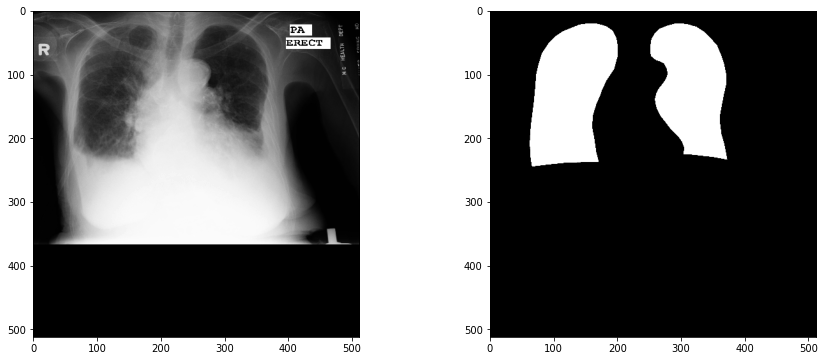

In [11]:
batch_index = 1
fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].imshow(np.squeeze(batch_data['image'][batch_index]), cmap='gray')
ax[1].imshow(np.squeeze(batch_data['mask'][batch_index]), cmap='gray')

## Step 2: Create `Network`

In [12]:
model = fe.build(
    model_fn=lambda: UNet(input_size=(1, 512, 512)),
    optimizer_fn=lambda x: torch.optim.Adam(params=x, lr=0.0001),
    model_name="lung_segmentation"
)

In [13]:
network = fe.Network(ops=[
    ModelOp(inputs="image", model=model, outputs="pred_segment"),
    CrossEntropy(inputs=("pred_segment", "mask"), outputs="loss", form="binary"),
    UpdateOp(model=model, loss_name="loss")
])

## Step 3: Create `Estimator`

In [14]:
traces = [
    Dice(true_key="mask", pred_key="pred_segment"),
    BestModelSaver(model=model, save_dir=save_dir, metric='Dice', save_best_mode='max')
]

In [15]:
estimator = fe.Estimator(network=network,
                         pipeline=pipeline,
                         epochs=epochs,
                         log_steps=20,
                         traces=traces,
                         max_train_steps_per_epoch=max_train_steps_per_epoch,
                         max_eval_steps_per_epoch=max_eval_steps_per_epoch)

# Training

In [16]:
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        



FastEstimator-Start: step: 1; num_device: 0; logging_interval: 20; 


FastEstimator-Train: step: 1; loss: 1.820353; 


FastEstimator-Train: step: 10; epoch: 1; epoch_time: 459.71 sec; 


FastEstimator-BestModelSaver: Saved model to /tmp/tmprka4zap9/lung_segmentation_best_Dice.pt
FastEstimator-Eval: step: 10; epoch: 1; loss: 0.48401085; Dice: 1.5618932890579209e-13; since_best_Dice: 0; max_Dice: 1.5618932890579209e-13; 


FastEstimator-Train: step: 20; loss: 0.5564093; steps/sec: 0.02; 
FastEstimator-Train: step: 20; epoch: 2; epoch_time: 461.31 sec; 


FastEstimator-BestModelSaver: Saved model to /tmp/tmprka4zap9/lung_segmentation_best_Dice.pt
FastEstimator-Eval: step: 20; epoch: 2; loss: 0.5173615; Dice: 0.6580485510089205; since_best_Dice: 0; max_Dice: 0.6580485510089205; 
FastEstimator-Finish: step: 20; total_time: 1051.15 sec; lung_segmentation_lr: 0.0001; 


# Inferencing

Let's visualize the prediction from the neural network. We select a random image from the dataset:

In [17]:
image_path = df['image'].sample(random_state=3).values[0]

## Pass the image through `Pipeline` and `Network`

We create a data dict, and call `Pipeline.transform()`.

In [18]:
data = {'image': image_path}
data = pipeline.transform(data, mode="infer")

After the `Pipeline`, we rebuild our model by providing the trained weights path and pass it to a new `Network`:

In [19]:
weights_path = os.path.join(save_dir, "lung_segmentation_best_Dice.pt") # your model_path

model = fe.build(model_fn=lambda: UNet(input_size=(1, 512, 512)),
                 optimizer_fn=lambda x: torch.optim.Adam(params=x, lr=0.0001),
                 model_name="lung_segmentation",
                 weights_path=weights_path)

In [20]:
network = fe.Network(ops=[ModelOp(inputs="image", model=model, outputs="pred_segment")])

We call `Network.transform()` to get outputs from our `Network`:

In [21]:
pred = network.transform(data, mode="infer")

## Visualize Outputs

In [22]:
img = np.squeeze(pred['image'].numpy())
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img_rgb = (img_rgb * 255).astype(np.uint8)

In [23]:
mask = pred['pred_segment'].numpy()
mask = np.squeeze(mask)
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
mask_rgb = (mask_rgb * 255).astype(np.uint8)

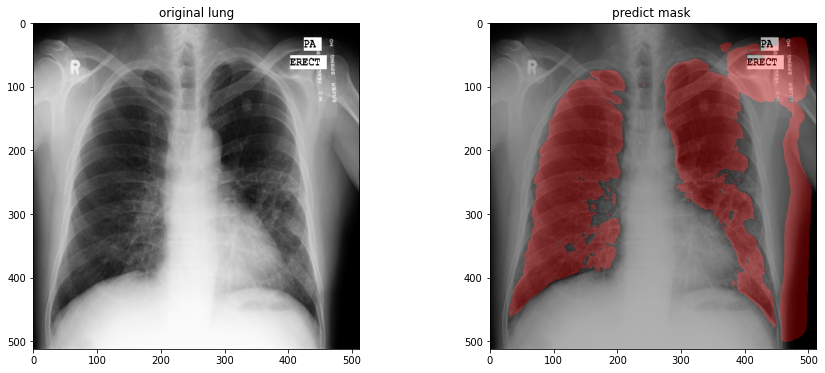

In [24]:
_, mask_thres = cv2.threshold(mask, 0.5, 1, cv2.THRESH_BINARY)
mask_overlay = mask_rgb * np.expand_dims(mask_thres, axis=-1)
mask_overlay = np.where(mask_overlay != [0, 0, 0], [255, 0, 0], [0, 0, 0])
mask_overlay = mask_overlay.astype(np.uint8)
img_with_mask = cv2.addWeighted(img_rgb, 0.7, mask_overlay, 0.3, 0)
maskgt_with_maskpred = cv2.addWeighted(mask_rgb, 0.7, mask_overlay, 0.3, 0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
ax[0].imshow(img_rgb)
ax[0].set_title('original lung')
ax[1].imshow(img_with_mask)
ax[1].set_title('predict mask ')
plt.show()